# Описание проекта
Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.
«В один клик» — современная компания, поэтому её руководство не хочет принимать решения просто так — только на основе анализа данных и бизнес-моделирования. У компании есть небольшой отдел цифровых технологий, и вам предстоит побыть в роли стажёра в этом отделе. 
Итак, вашему отделу поручили разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

## Загрузка данных

<div style="background-color:lavender; color:#black; text-align:left; padding:2%">
<font size="4", color= "black">Выполним необходимые импорты</font>

In [226]:
!pip install phik
!pip install shap
!pip install scikit-learn==1.6.0 -q
!pip install matplotlib==3.5.1 -q
!pip install missingno

  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [980 lines of output]
      /private/var/folders/cs/qftmyy3d7qld8xvg13pxs3cr0000gn/T/pip-install-4xaw2ly4/matplotlib_e2f99f3d474c40deb3c3cc86daf2ea64/setup.py:70: SetuptoolsDeprecationWarning: The test command is disabled and references to it are deprecated.
      !!
      
              ********************************************************************************
              Please remove any references to `setuptools.command.test` in all supported versions of the affected package.
      
              This deprecation is overdue, please update your project and remove deprecated
              calls to avoid build errors in the future.
              ********************************************************************************
      
      !!
        class NoopTestCommand(setuptools.command.test.test):
      
      Edit mplsetup.cfg to change the build option

In [227]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn
import scipy.stats as st
import phik
import shap
import warnings
import missingno as msno

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, \
StandardScaler, MinMaxScaler, LabelEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.inspection import permutation_importance
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, \
accuracy_score, recall_score, precision_score, confusion_matrix, roc_auc_score
from phik import resources, report, phik_matrix
from phik.report import plot_correlation_matrix
from matplotlib.patches import Patch

pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.2f}'.format

warnings.filterwarnings(
    "ignore",
    message=".*default behavior of `mode`.*",
    category=FutureWarning
)

In [228]:
RANDOM_STATE = 42

In [229]:
DEFAULT_PALETTE = [
    "#FF9999",  # розовый
    "#66B3FF",  # голубой
    "#99FF99",  # салатовый
    "#FFCC99",  # персиковый
    "#ff8c69",  # лососевый
    "#acb78e",  # болотный
    # можно добавить ещё цвета при необходимости
]

In [230]:
def missing_report(df):
    """
    Генерирует отчёт по пропущенным значениям в DataFrame.

    Функция вычисляет для каждого столбца:
      - общее количество пропущенных значений,
      - долю пропущенных значений от общего числа строк (в процентах, с точностью до 2 знаков).

    Результатом является новый DataFrame с двумя колонками:
      - `missing_values`: количество пропусков в столбце,
      - `% of total`: процент пропусков от общего числа строк.

    Столбцы в отчёте отсортированы по убыванию количества пропущенных значений.

    Args:
        df (pandas.DataFrame): Исходный DataFrame для анализа пропусков.

    Returns:
        pandas.DataFrame: Отчёт с количеством и процентом пропусков для каждого столбца.
    """
    cnt = df.isna().sum()
    pct = (cnt / len(df) * 100).round(2)
    report = (
        pd.concat([cnt, pct], axis=1, keys=['missing_values', '% of total'])
          .sort_values('missing_values', ascending=False)
    )
    return report

In [231]:
def duplicate_report(df):
    """
    Генерирует отчёт по дублированным строкам в DataFrame.

    Функция вычисляет общее число строк-дубликатов в переданном DataFrame
    и рассчитывает их долю от общего количества строк в процентах (с точностью до 2 знаков).

    Args:
        df (pandas.DataFrame): Исходный DataFrame для анализа дубликатов.

    Returns:
        pandas.DataFrame: Однострочный отчёт с двумя колонками:
            - `duplicate_rows`: количество повторяющихся строк,
            - `% of total`: процент дубликатов от общего числа строк.
    """
    total = len(df)
    dup_cnt = df.duplicated().sum()
    dup_pct = (dup_cnt / total * 100).round(2)
    report = pd.DataFrame({
        'duplicate_rows': [dup_cnt],
        '% of total':    [dup_pct]
    }, index=[''])
    return report

In [232]:
def normalize_text(df, cols=None):
    """
    Нормализует текстовые столбцы в DataFrame.

    Функция создаёт копию переданного DataFrame и приводит все значения в указанных
    текстовых столбцах к одному виду: преобразует в нижний регистр, убирает лишние
    пробелы в начале и конце строк, а также заменяет последовательности из
    нескольких пробельных символов одним пробелом.

    Args:
        df (pandas.DataFrame): Исходный DataFrame, содержищий столбцы для нормализации.
        cols (list of str or None, optional): Список имён столбцов, над которыми нужно
            выполнить нормализацию. Если None, то автоматически выбираются все
            столбцы типов object, string или category. По умолчанию None.

    Returns:
        pandas.DataFrame: Копия исходного DataFrame, в которой указанные столбцы
            содержат нормализованные текстовые значения. Пропущенные значения не трогаются.
    """   
    df_norm = df.copy()
    if cols is None:
        cols = df_norm.select_dtypes(include=['object', 'string', 'category']).columns

    for col in cols:
        s = df_norm[col]
        mask = s.notna()
        df_norm.loc[mask, col] = (
            s[mask]
            .astype(str)
            .str.lower()
            .str.strip()
            .str.replace(r'\s+', ' ', regex=True)
        )
    return df_norm

In [233]:
def text_dup_report(df):
    """
    Выводит отчёт о повторяющихся и уникальных текстовых значениях в DataFrame.

    Для каждого текстового столбца (типов object, string или category):
      - подсчитывается число уникальных значений (без учёта NaN);
      - выводится имя столбца и количество уникальных значений;
      - если число уникальных значений меньше 10, дополнительно выводятся частоты
        всех значений (включая NaN).

    Args:
        df (pandas.DataFrame): Исходный DataFrame для анализа текстовых столбцов.

    Returns:
        None: Функция выводит результаты в консоль и не возвращает DataFrame.
    """
    text_cols = df.select_dtypes(include=['object', 'string', 'category']).columns

    for col in text_cols:
        n_unique = df[col].nunique(dropna=True)

        print(f"--- Column: \033[0;34m{col}\033[0m ---")
        print(f"Unique values: {n_unique}")

        if n_unique < 10:
            print("Value counts:")
            print(df[col].value_counts(dropna=False))

        print()

In [234]:
def plot_hist_and_box(data, 
                      column='active_6m', 
                      bins=40, 
                      figsize=(16,8), 
                      hist_title='Гистограмма', 
                      box_title='Диаграмма размаха',
                      axis_label='Заголовок по оси X',
                      suptitle='Общий заголовок', 
                     ):
    """
    Строит рядом гистограмму и диаграмму размаха для одного столбца DataFrame.

    Функция создаёт две панели в одной фигуре:
      1. Гистограмма распределения значений с оценкой плотности (kde) и вертикальной 
         линией, обозначающей медиану.
      2. Диаграмма размаха (boxplot), показывающая разброс и выбросы.

    Args:
        data (pandas.DataFrame): Исходный DataFrame с данными.
        column (str): Имя числового столбца, по которому строятся графики. 
            По умолчанию 'active_6m'.
        bins (int): Число корзин (bins) для гистограммы. По умолчанию 40.
        figsize (tuple of int): Размер фигуры в дюймах (width, height). 
            По умолчанию (16, 8).
        hist_title (str): Заголовок над гистограммой. По умолчанию 'Гистограмма'.
        box_title (str): Заголовок над диаграммой размаха. По умолчанию 'Диаграмма размаха'.
        axis_label (str): Подпись по оси X для гистограммы. По умолчанию 'Заголовок по оси X'.
        suptitle (str): Общий заголовок всей фигуры. По умолчанию 'Общий заголовок'.

    Returns:
        None: Функция отображает графики и не возвращает значение.
    """
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=figsize)

    # Гистограмма с линией медианы
    sns.histplot(data=data, x=column, ax=axs[0], bins=bins, kde=True)
    median_val = data[column].median()
    axs[0].axvline(median_val, linestyle='--', label='Медиана')
    axs[0].legend()
    axs[0].set_xlabel(axis_label)
    axs[0].set_ylabel('Количество покупателей')
    axs[0].set_title(hist_title)

    # Диаграмма размаха
    sns.boxplot(data=data, x=column, ax=axs[1])
    axs[1].set_title(box_title)

    fig.suptitle(suptitle)
    plt.tight_layout()
    plt.show()

In [235]:
def plot_two_pie_charts(data, columns, titles, palette=None, figsize=(12, 6)):
    """
    Строит два pie-чарта с возможностью передать свою палитру.
    Если palette=None, берётся DEFAULT_PALETTE.
    """
    if palette is None:
        palette = DEFAULT_PALETTE

    if len(columns) != 2 or len(titles) != 2:
        raise ValueError("Пожалуйста, передайте ровно два столбца и два заголовка.")
    
    fig, axs = plt.subplots(1, 2, figsize=figsize)
    for ax, col, title in zip(axs, columns, titles):
        data[col].value_counts().plot(
            kind='pie',
            autopct='%1.0f%%',
            title=title,
            colors=palette,
            ax=ax
        )
        ax.set_xlabel('')
        ax.set_ylabel('')
    plt.tight_layout()
    plt.show()

In [236]:
def plot_scatter(data, x, hue, title, figsize=(12, 8)):
    """
    Строит точечную диаграмму (scatter plot) зависимости значения заданного признака от прибыли.

    Диаграмма отображает на оси X значения столбца `x`, на оси Y — фиксированного целевого столбца
    `profit_rub`. Точки раскрашиваются по категориям из столбца `hue` и масштабируются по размеру
    в зависимости от столбца `type_service`.

    Args:
        data (pandas.DataFrame): Исходный DataFrame с данными.
        x (str): Название столбца, значения которого откладываются по горизонтальной оси.
        hue (str): Название категориального столбца для раскраски точек.
        title (str): Заголовок графика.
        figsize (tuple of int, optional): Размер фигуры в дюймах (width, height). По умолчанию (12, 8).

    Returns:
        None: Функция отображает график и не возвращает значение.
    """
    target = 'profit_rub'
    size = 'type_service'
    
    plt.figure(figsize=figsize)
    sns.scatterplot(data=data, x=x, y=target, hue=hue, size=size)
    plt.title(title, fontsize=12)
    plt.xlabel(x, fontsize=12)
    plt.ylabel(target, fontsize=12)
    plt.show()

In [237]:
def plot_segment_comparison(
    df_1,                      # df_1, df_2: DataFrames с одинаковыми столбцами
    df_2,
    groupby_cols,              # список колонок для группировки
    value_col,                 # колонка с числовым значением
    segment_names=('сегмент_1', 'сегмент_2'),
    top_n=None                 # сколько категорий показать (по убыванию); если None — все
):
    """
    Сравнивает два сегмента данных с помощью горизонтальных стопочных диаграмм.

    Для каждого из двух переданных DataFrame (df_1 и df_2) выполняется:
      1. Группировка по колонкам groupby_cols и суммирование значений в колонке value_col.
      2. Разворачивание последнего уровня индекса (unstack) для получения столбцов-категорий.
      3. Сортировка категорий по общей сумме по убыванию.
      4. Опциональное ограничение числа отображаемых категорий top_n.

    Затем строятся рядом две barh-диаграммы, на которых отображается распределение
    value_col по группам из groupby_cols для первого и второго сегмента соответственно.
    Общая легенда категорий выводится внизу фигуры.

    Args:
        df_1 (pandas.DataFrame): Данные первого сегмента.
        df_2 (pandas.DataFrame): Данные второго сегмента (аналогичной структуры).
        groupby_cols (list of str): Список колонок для группировки (порядок важен —
            последняя колонка станет уровнями в легенде).
        value_col (str): Название числовой колонки, значения которой складываются.
        segment_names (tuple of str, optional): Имена, отображаемые в заголовках
            левого и правого графиков. По умолчанию ('сегмент_1', 'сегмент_2').
        top_n (int or None, optional): Сколько верхних по сумме групп показать.
            Если None, отображаются все.

    Returns:
        None: Функция отображает фигуру с двумя бар-чартами и не возвращает значений.
    """
    def prepare(df):
        grp = (df
               .groupby(groupby_cols, observed=True)[value_col]
               .sum()
               .unstack(fill_value=0))
        order = grp.sum(axis=1).sort_values(ascending=False).index
        grp = grp.loc[order]
        if top_n is not None:
            grp = grp.head(top_n)
        return grp

    data_1 = prepare(df_1)
    data_2 = prepare(df_2)

    fig, axes = plt.subplots(ncols=2, figsize=(20, 10), sharey=True)

    # Левый график
    data_1.plot(
        kind='barh',
        stacked=True,
        color=colors,
        ax=axes[0]
    )
    axes[0].set_title(f'{segment_names[0]}: \n{value_col} по {", ".join(groupby_cols)}')
    axes[0].set_xlabel(value_col)
    axes[0].set_ylabel(groupby_cols[0])

    # Правый график
    data_2.plot(
        kind='barh',
        stacked=True,
        color=colors,
        ax=axes[1]
    )
    axes[1].set_title(f'{segment_names[1]}: \n{value_col} по {", ".join(groupby_cols)}')
    axes[1].set_xlabel(value_col)
    axes[1].set_ylabel('')

    # Общая легенда внизу
    handles, labels = axes[1].get_legend_handles_labels()
    fig.legend(
        handles, labels,
        title=groupby_cols[-1],
        loc='lower center',
        ncol=len(labels)
    )

    plt.tight_layout(rect=[0, 0.05, 1, 1])
    plt.show()

<div style="background-color:lavender; color:#black; text-align:left; padding:2%">
<font size="4", color= "black"> 1.1. Загрузим данные из csv-файлов в датафреймы c помощью библиотеки pandas</font>

In [238]:
try:
    market = pd.read_csv('data/market_file.csv')
except FileNotFoundError:
    market = pd.read_csv('market_file.csv')

market.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

In [239]:
market = market.rename(columns={'Покупательская активность': 'activity', 'Тип сервиса': 'type_service', \
                    'Разрешить сообщать': 'reporting', 'Маркет_актив_6_мес': 'active_6m', \
                   'Маркет_актив_тек_мес': 'active_current', 'Длительность': 'duration', \
                    'Акционные_покупки': 'promo_purchases', 'Популярная_категория': 'popular_category', \
                    'Средний_просмотр_категорий_за_визит': 'views_visit', \
                    'Неоплаченные_продукты_штук_квартал': 'unpaid_pcs', \
                   'Ошибка_сервиса': 'service_error', 'Страниц_за_визит': 'pages_visit'})

In [240]:
market.head()

id   activity type_service reporting  active_6m  active_current  \
0  215348  Снизилась      премиум        да       3.40               5   
1  215349  Снизилась      премиум        да       4.40               4   
2  215350  Снизилась    стандартт       нет       4.90               3   
3  215351  Снизилась    стандартт        да       3.20               5   
4  215352  Снизилась    стандартт       нет       5.10               3   

   duration  promo_purchases   popular_category  views_visit  unpaid_pcs  \
0       121             0.00   Товары для детей            6           2   
1       819             0.75   Товары для детей            4           4   
2       539             0.14  Домашний текстиль            5           2   
3       896             0.99   Товары для детей            5           0   
4      1064             0.94   Товары для детей            3           2   

   service_error  pages_visit  
0              1            5  
1              2            5  
2              1            5  
3              6            4  
4              3            2

In [241]:
try:
    mmoney = pd.read_csv('data/market_money.csv')
except FileNotFoundError:
    mmoney = pd.read_csv('market_money.csv')

mmoney.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [242]:
mmoney = mmoney.rename(columns={'Период': 'period', 'Выручка': 'revenue'})

In [243]:
mmoney.head()

id               period  revenue
0  215348  препредыдущий_месяц     0.00
1  215348        текущий_месяц 3,293.10
2  215348     предыдущий_месяц     0.00
3  215349  препредыдущий_месяц 4,472.00
4  215349        текущий_месяц 4,971.60

In [244]:
try:
    mtime = pd.read_csv('data/market_time.csv')
except FileNotFoundError:
    mtime = pd.read_csv('market_time.csv')

mtime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [245]:
mtime = mtime.rename(columns={'Период': 'period', 'минут': 'minutes'})

In [246]:
mtime.head()

id            period  minutes
0  215348     текущий_месяц       14
1  215348  предыдцщий_месяц       13
2  215349     текущий_месяц       10
3  215349  предыдцщий_месяц       12
4  215350     текущий_месяц       13

In [247]:
try:
    money = pd.read_csv('data/money.csv', sep = ';', decimal = ',')
except FileNotFoundError:
    money = pd.read_csv('money.csv', sep = ';', decimal = ',')

money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


In [248]:
money = money.rename(columns={'Прибыль': 'profit'})

In [249]:
money.head()

id  profit
0  215348    0.98
1  215349    4.16
2  215350    3.13
3  215351    4.87
4  215352    4.21

<div style="background-color:aquamarine; color:#black; text-align:left; padding:2%">
<font size="4", color= "black"><b>Результат:</b> мы сделали необходимые импорты, создали датафреймы, изучили данные и переименовали некоторые столбцы.</font>

## Предобработка данных

<div style="background-color:lavender; color:#black; text-align:left; padding:2%">
<font size="4", color= "black">Посмотрим пропуски в данных</font>

In [250]:
dfs = {
    'market_file': market,
    'market_money': mmoney,
    'market_time': mtime,
    'money': money
}

In [251]:
reports = {name: missing_report(df) for name, df in dfs.items()}

for name, df in dfs.items():
    print(f"=== \033[1;34m{name}\033[0m ===")
    print(missing_report(df), "\n")

=== market_file ===
                  missing_values  % of total
id                             0        0.00
activity                       0        0.00
type_service                   0        0.00
reporting                      0        0.00
active_6m                      0        0.00
active_current                 0        0.00
duration                       0        0.00
promo_purchases                0        0.00
popular_category               0        0.00
views_visit                    0        0.00
unpaid_pcs                     0        0.00
service_error                  0        0.00
pages_visit                    0        0.00 

=== market_money ===
         missing_values  % of total
id                    0        0.00
period                0        0.00
revenue               0        0.00 

=== market_time ===
         missing_values  % of total
id                    0        0.00
period                0        0.00
minutes               0        0.00 

=== money ===
 

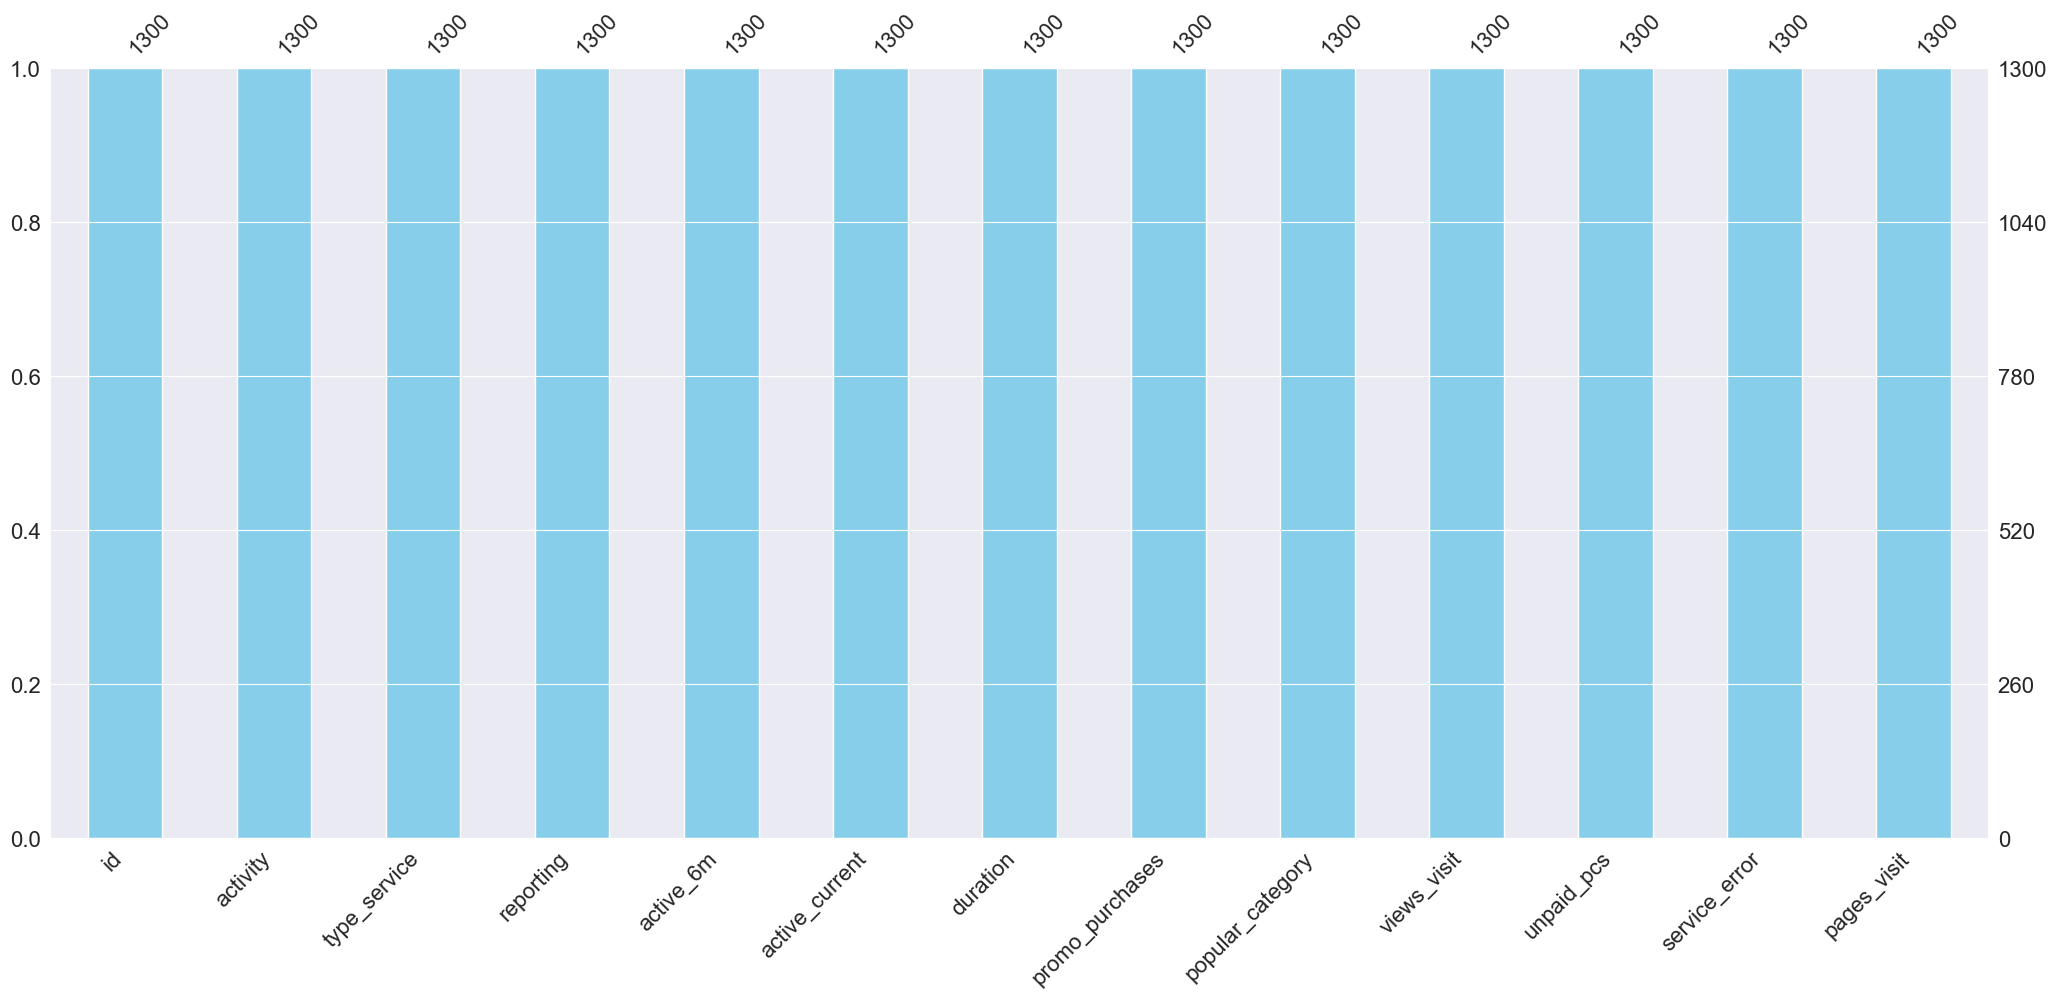

In [252]:
msno.bar(market, color='skyblue');

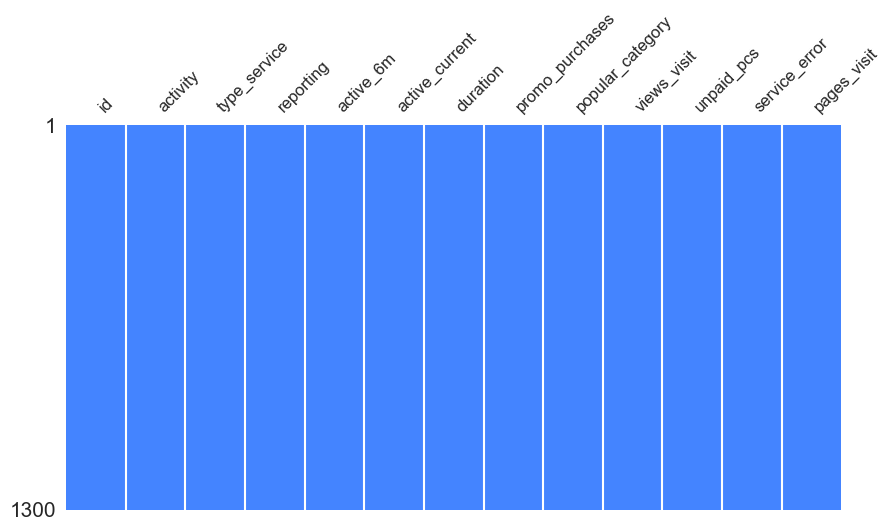

In [253]:
msno.matrix(
    market,
    sparkline=False,
    figsize=(10, 5),
    fontsize=12,
    color=(0.27, 0.52, 1.0)
);

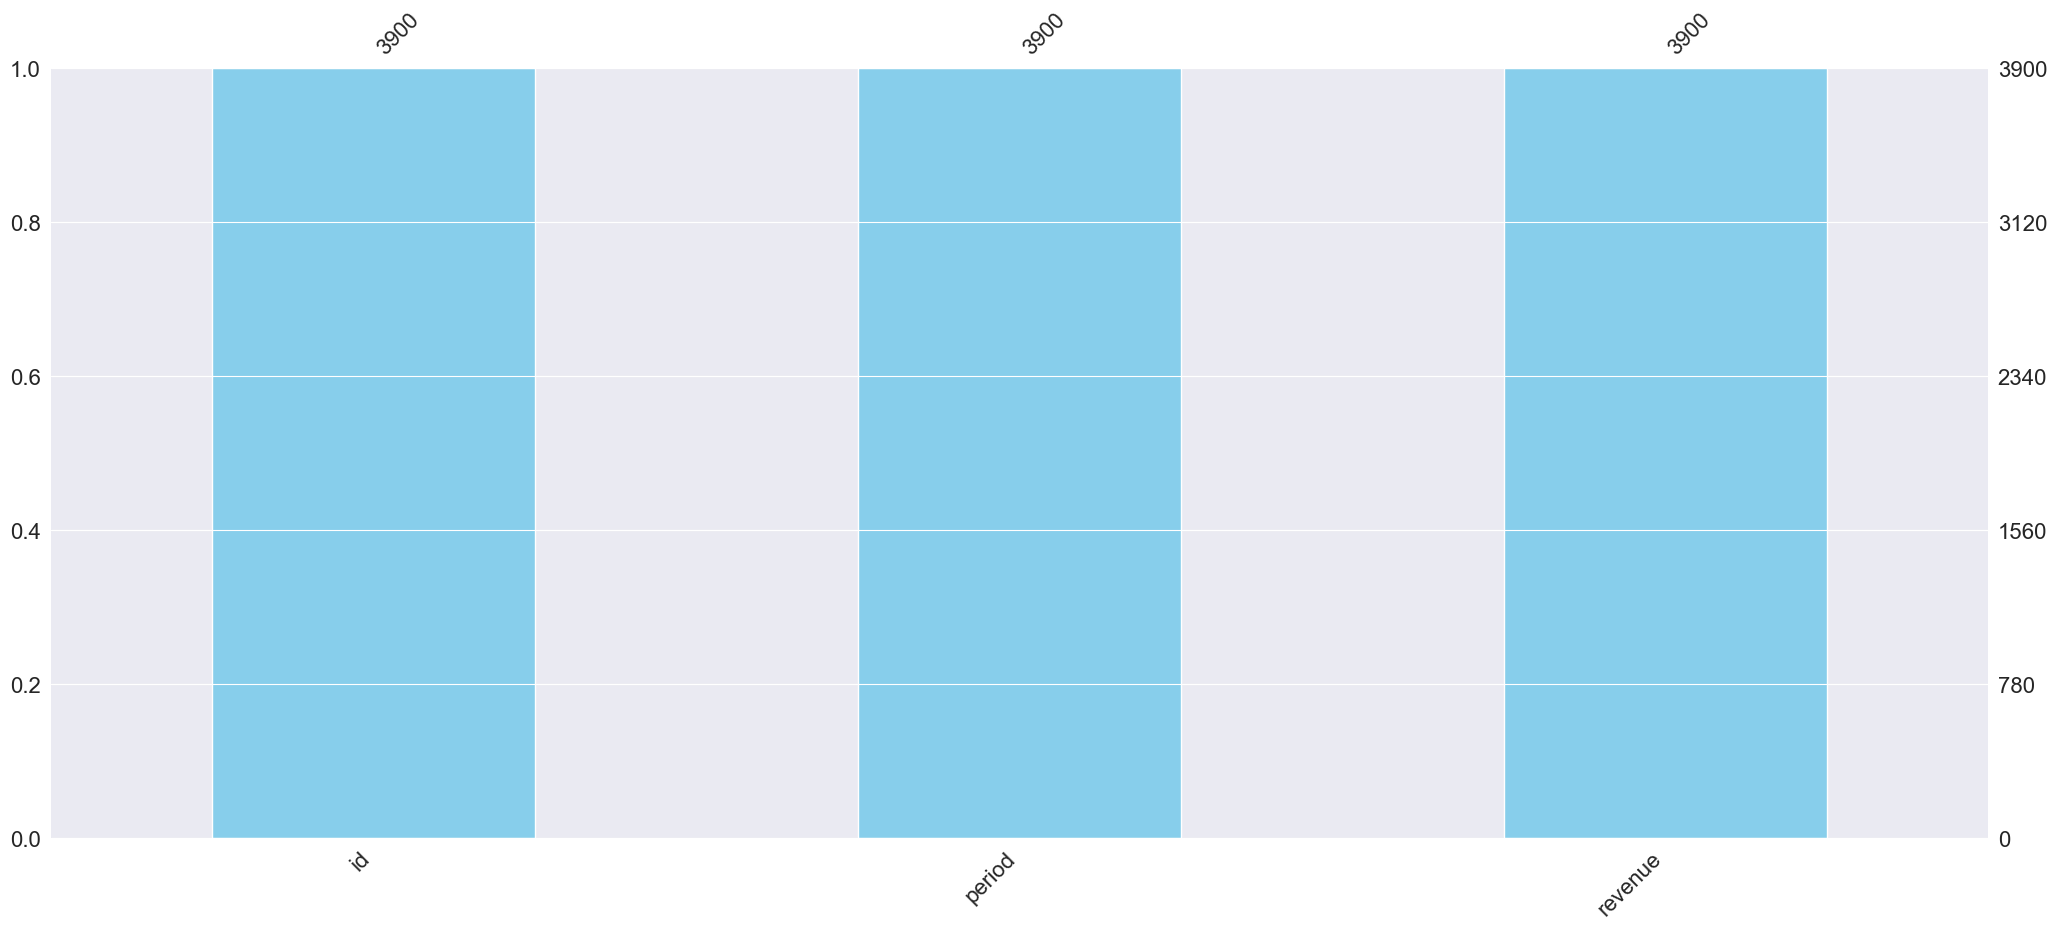

In [254]:
msno.bar(mmoney, color='skyblue');

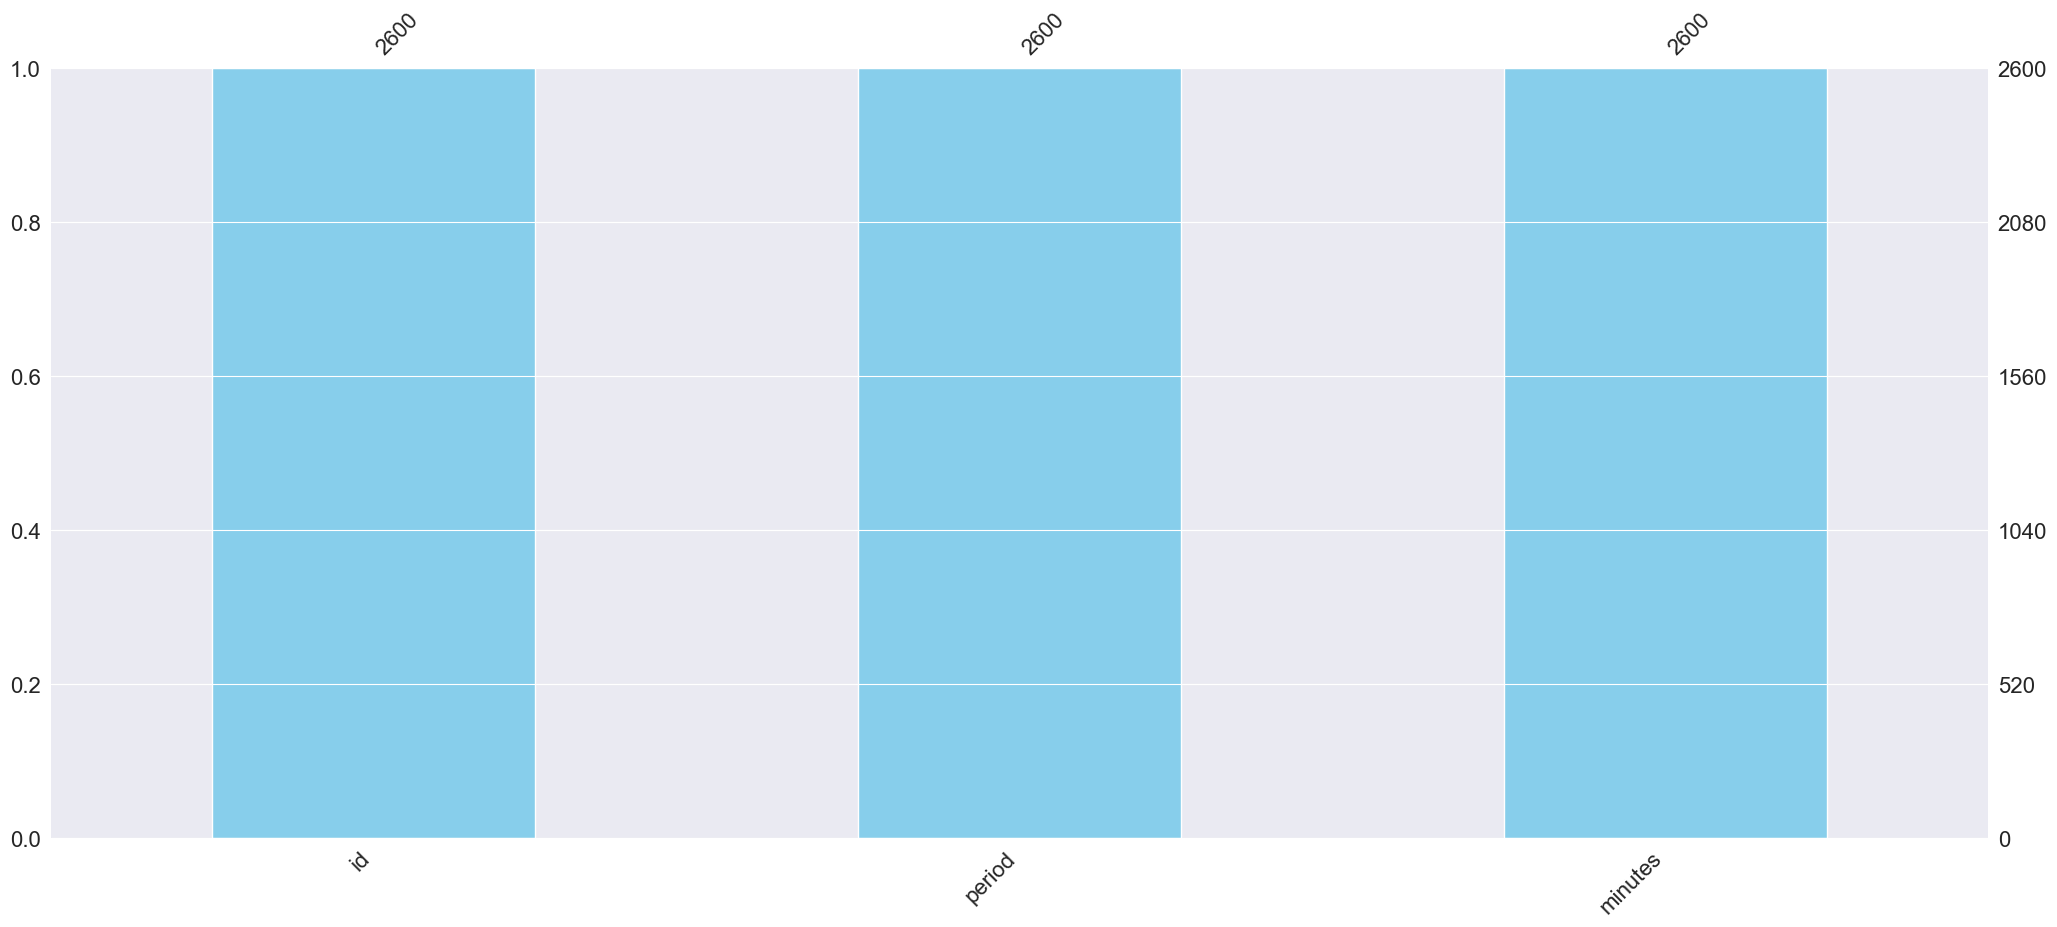

In [255]:
msno.bar(mtime, color='skyblue');

<div style="background-color:lavender; color:#black; text-align:left; padding:2%">
<font size="4", color= "black">Посмотрим явные дубликаты</font>

In [256]:
dup_reports = {name: duplicate_report(df) for name, df in dfs.items()}

for name, rep in dup_reports.items():
    print(f"=== \033[1;34m{name} — дубликаты\033[0m ===")
    print(rep, "\n")


=== market_file — дубликаты ===
  duplicate_rows  % of total
               0        0.00 

=== market_money — дубликаты ===
  duplicate_rows  % of total
               0        0.00 

=== market_time — дубликаты ===
  duplicate_rows  % of total
               0        0.00 

=== money — дубликаты ===
  duplicate_rows  % of total
               0        0.00 



<div style="background-color:lavender; color:#black; text-align:left; padding:2%">
<font size="4", color= "black">Посмотрим не явные дубликаты в текстовых столбцах, для уникальных значений меньше 10 посмотрим эти значения</font>

In [257]:
normalized_dfs = {name: normalize_text(df) for name, df in dfs.items()}

market, mmoney, mtime, money = (
    normalized_dfs['market_file'],
    normalized_dfs['market_money'],
    normalized_dfs['market_time'],
    normalized_dfs['money']
)

In [258]:
for name, df in dfs.items():
    print(f"=== \033[1;34m{name}\033[0m ===")
    text_dup_report(df)

=== market_file ===
--- Column: activity ---
Unique values: 2
Value counts:
activity
Прежний уровень    802
Снизилась          498
Name: count, dtype: int64

--- Column: type_service ---
Unique values: 3
Value counts:
type_service
стандарт     914
премиум      376
стандартт     10
Name: count, dtype: int64

--- Column: reporting ---
Unique values: 2
Value counts:
reporting
да     962
нет    338
Name: count, dtype: int64

--- Column: popular_category ---
Unique values: 6
Value counts:
popular_category
Товары для детей                        330
Домашний текстиль                       251
Косметика и аксесуары                   223
Техника для красоты и здоровья          184
Мелкая бытовая техника и электроника    174
Кухонная посуда                         138
Name: count, dtype: int64

=== market_money ===
--- Column: period ---
Unique values: 3
Value counts:
period
препредыдущий_месяц    1300
текущий_месяц          1300
предыдущий_месяц       1300
Name: count, dtype: int64

=== market

In [259]:
market['type_service'] = market['type_service'].replace({'стандартт': 'стандарт'})
market['popular_category'] = market['popular_category'].replace({
    'косметика и аксесуары': 'косметика и аксессуары'
})
mtime['period'] = mtime['period'].replace({'предыдцщий_месяц': 'предыдущий_месяц'})

dfs = {
    'market_file': market,
    'market_money': mmoney,
    'market_time': mtime,
    'money': money
}

In [260]:
# Проверим корректировки
for name, df in dfs.items():
    print(f"=== \033[1;34m{name}\033[0m ===")
    text_dup_report(df)

=== market_file ===
--- Column: activity ---
Unique values: 2
Value counts:
activity
прежний уровень    802
снизилась          498
Name: count, dtype: int64

--- Column: type_service ---
Unique values: 2
Value counts:
type_service
стандарт    924
премиум     376
Name: count, dtype: int64

--- Column: reporting ---
Unique values: 2
Value counts:
reporting
да     962
нет    338
Name: count, dtype: int64

--- Column: popular_category ---
Unique values: 6
Value counts:
popular_category
товары для детей                        330
домашний текстиль                       251
косметика и аксессуары                  223
техника для красоты и здоровья          184
мелкая бытовая техника и электроника    174
кухонная посуда                         138
Name: count, dtype: int64

=== market_money ===
--- Column: period ---
Unique values: 3
Value counts:
period
препредыдущий_месяц    1300
текущий_месяц          1300
предыдущий_месяц       1300
Name: count, dtype: int64

=== market_time ===
--- Colum

<div style="background-color:aquamarine; color:#black; text-align:left; padding:2%">
<font size="4", color= "black"><b>Результат:</b> пропусков в данных нет, явные и не явные дубликаты обработаны</font>

## Исследовательский анализ данных

<div style="background-color:lavender; color:#black; text-align:left; padding:2%">
<font size="4", color= "black">Проведем исследовательский анализ данных из каждой таблицы. Отберем клиентов с покупательской активностью не менее трёх месяцев, то есть таких, которые что-либо покупали в этот период</font>

In [261]:
# Отберем клиентов с покупательской активностью не менее трёх месяцев
active_ids = (
    dfs['market_money']
      .groupby('id')['revenue']
      .min()
      .gt(0)
      .pipe(lambda s: s[s].index)
)

filtered = {
    name: df[df['id'].isin(active_ids)].reset_index(drop=True)
    for name, df in dfs.items()
}

market, mmoney, mtime, money = (
    filtered['market_file'],
    filtered['market_money'],
    filtered['market_time'],
    filtered['money']
)

In [262]:
market.describe()

id  active_6m  active_current  duration  promo_purchases  \
count   1,297.00   1,297.00        1,297.00  1,297.00         1,297.00   
mean  215,998.99       4.25            4.01    602.99             0.32   
std       374.58       1.02            0.70    249.10             0.25   
min   215,349.00       0.90            3.00    121.00             0.11   
25%   215,675.00       3.70            4.00    410.00             0.17   
50%   215,999.00       4.20            4.00    607.00             0.24   
75%   216,323.00       4.90            4.00    806.00             0.30   
max   216,647.00       6.60            5.00  1,079.00             0.99   

       views_visit  unpaid_pcs  service_error  pages_visit  
count     1,297.00    1,297.00       1,297.00     1,297.00  
mean          3.27        2.84           4.18         8.19  
std           1.35        1.97           1.95         3.98  
min           1.00        0.00           0.00         1.00  
25%           2.00        1.00           3.00         5.00  
50%           3.00        3.00           4.00         8.00  
75%           4.00        4.00           6.00        11.00  
max           6.00       10.00           9.00        20.00

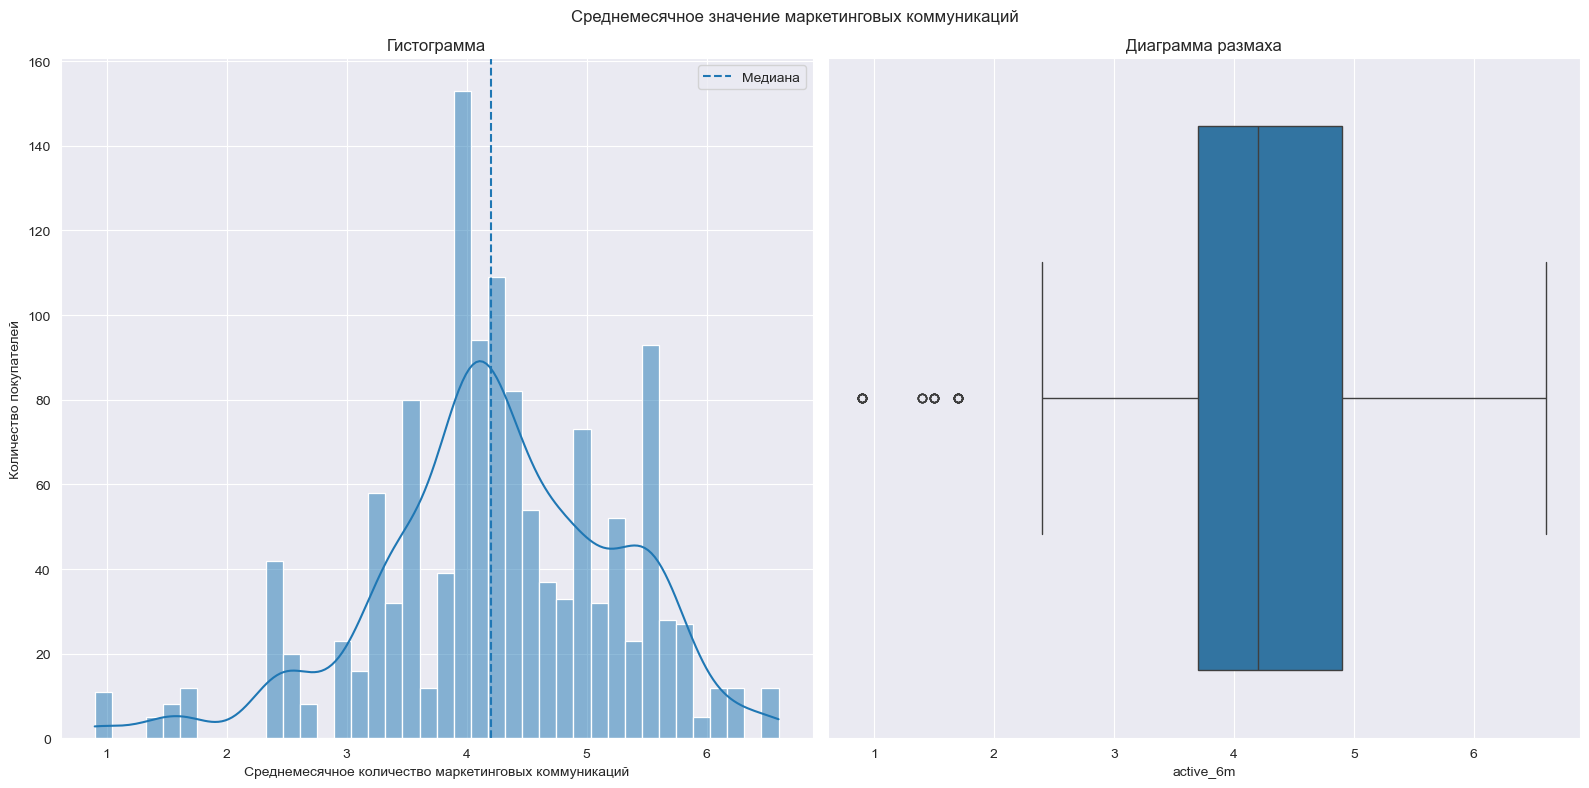

In [263]:
plot_hist_and_box(market, 
                  column='active_6m', 
                  axis_label='Среднемесячное количество маркетинговых коммуникаций',
                  suptitle='Среднемесячное значение маркетинговых коммуникаций'
                 )

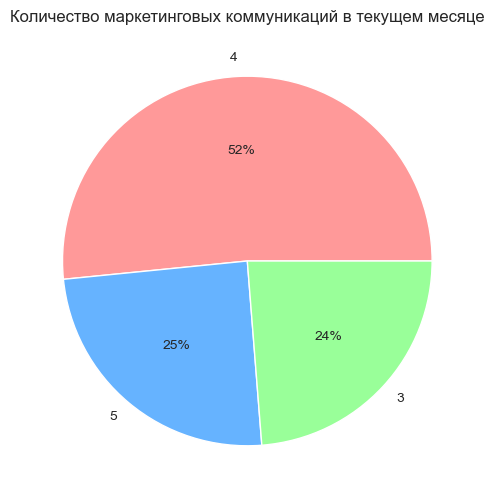

In [264]:
market['active_current'].value_counts().plot(
    y = 'count', 
    kind = 'pie', 
    autopct='%1.0f%%', 
    title = 'Количество маркетинговых коммуникаций в текущем месяце', 
    colors = DEFAULT_PALETTE, 
    figsize = (12, 6),
    ylabel=''
)
plt.show()

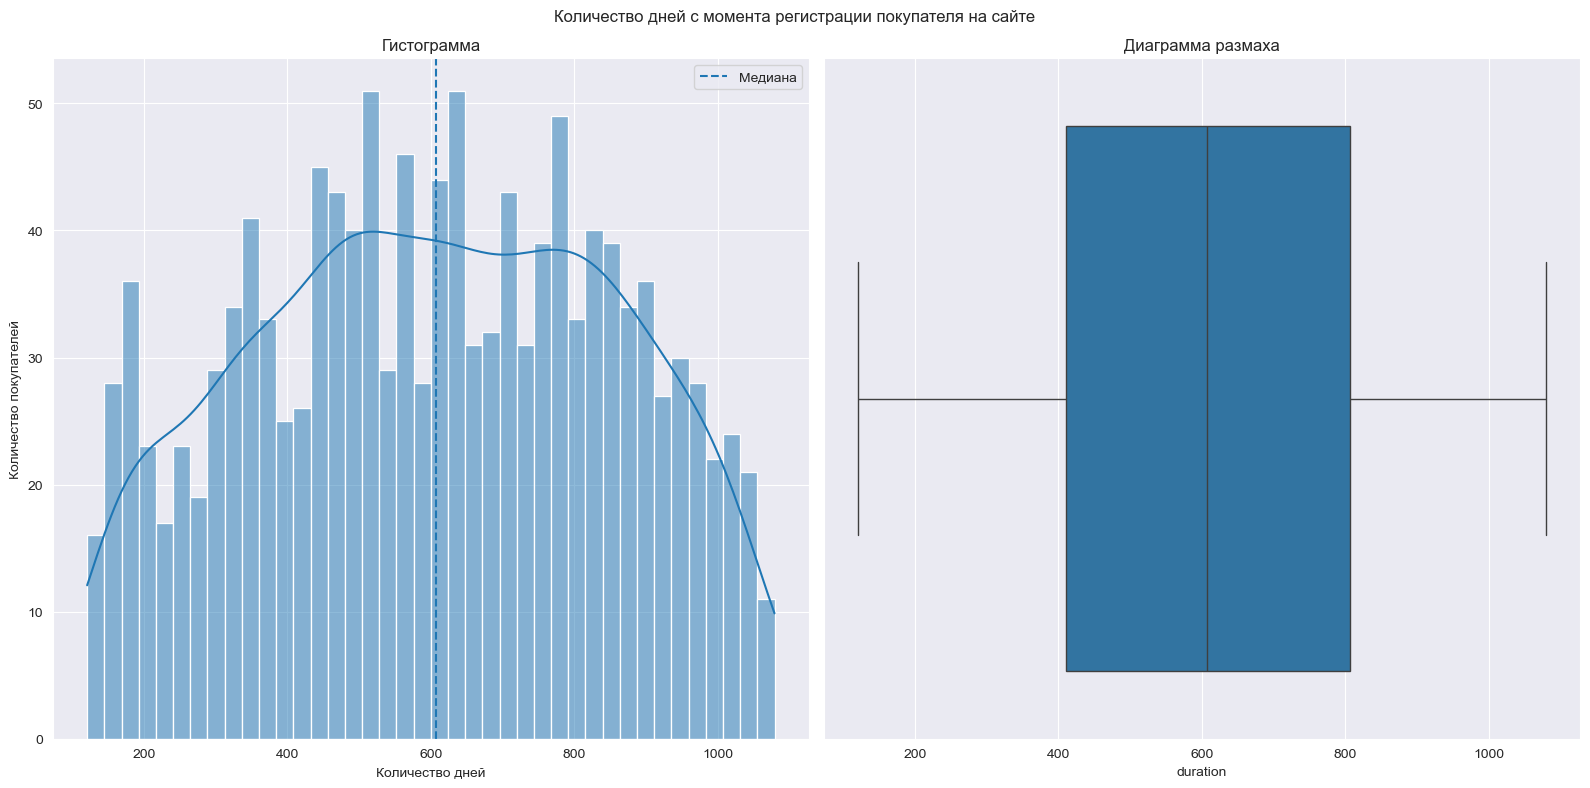

In [265]:
plot_hist_and_box(market, 
                  column='duration', 
                  axis_label='Количество дней',
                  suptitle='Количество дней с момента регистрации покупателя на сайте'
                 )

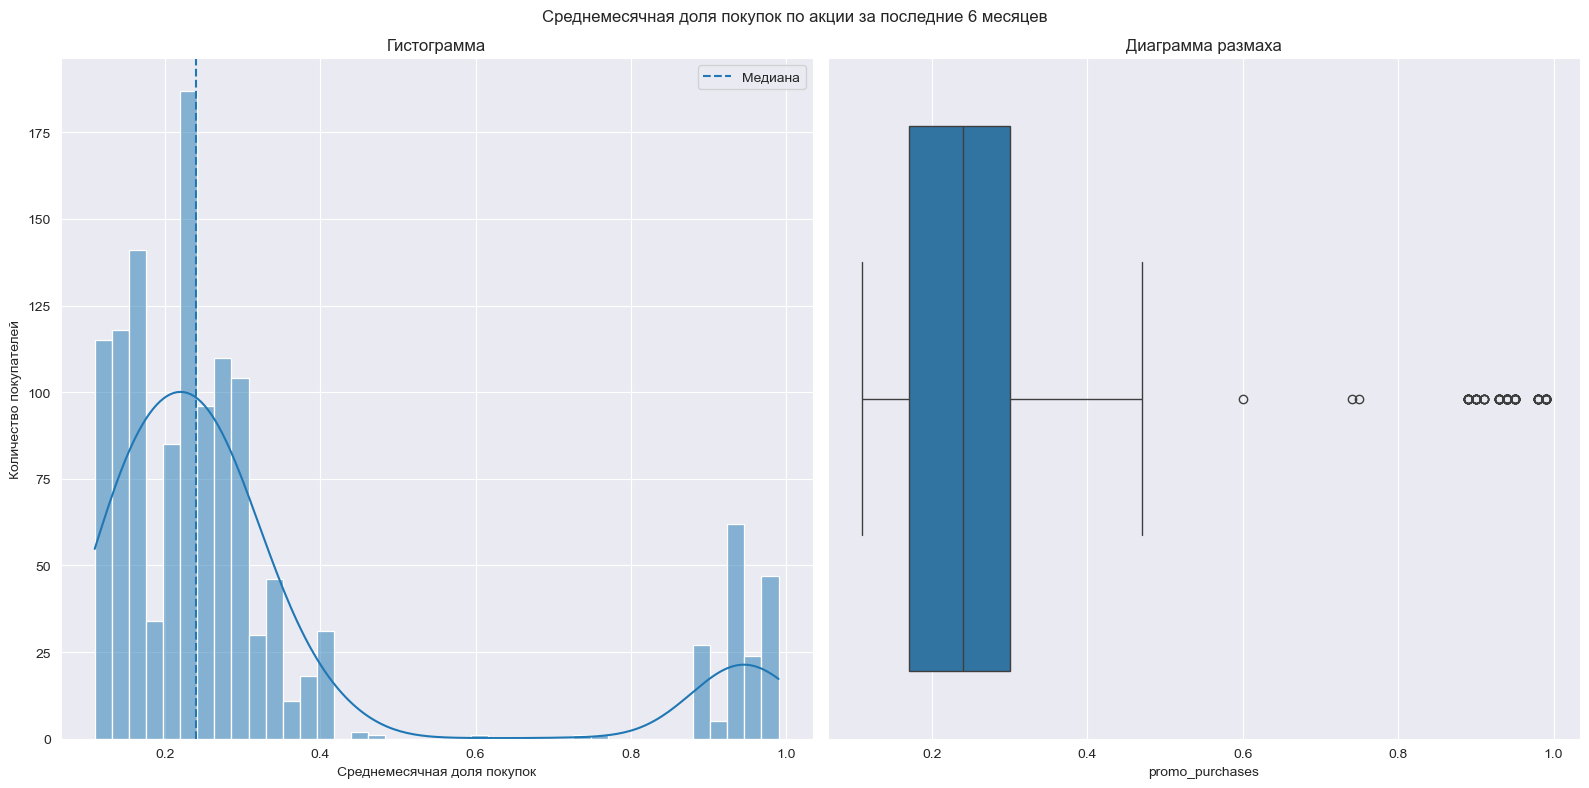

In [266]:
plot_hist_and_box(market, 
                  column='promo_purchases', 
                  axis_label='Среднемесячная доля покупок',
                  suptitle='Среднемесячная доля покупок по акции за последние 6 месяцев'
                 )

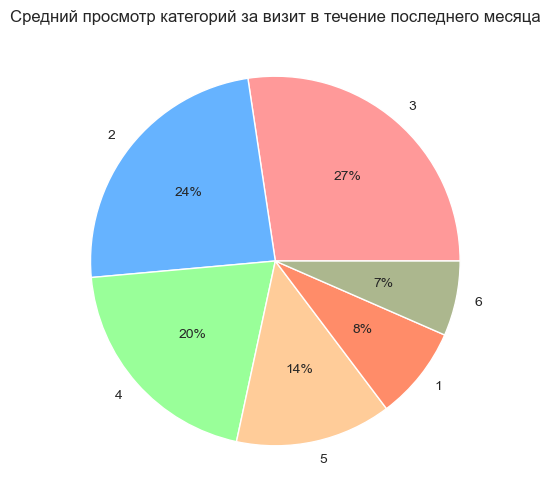

In [267]:
market['views_visit'].value_counts().plot(
    y = 'count', 
    kind = 'pie', 
    autopct='%1.0f%%', 
    title = 'Средний просмотр категорий за визит в течение последнего месяца', 
    colors = DEFAULT_PALETTE, 
    figsize = (12, 6),
    ylabel=''
)
plt.show()

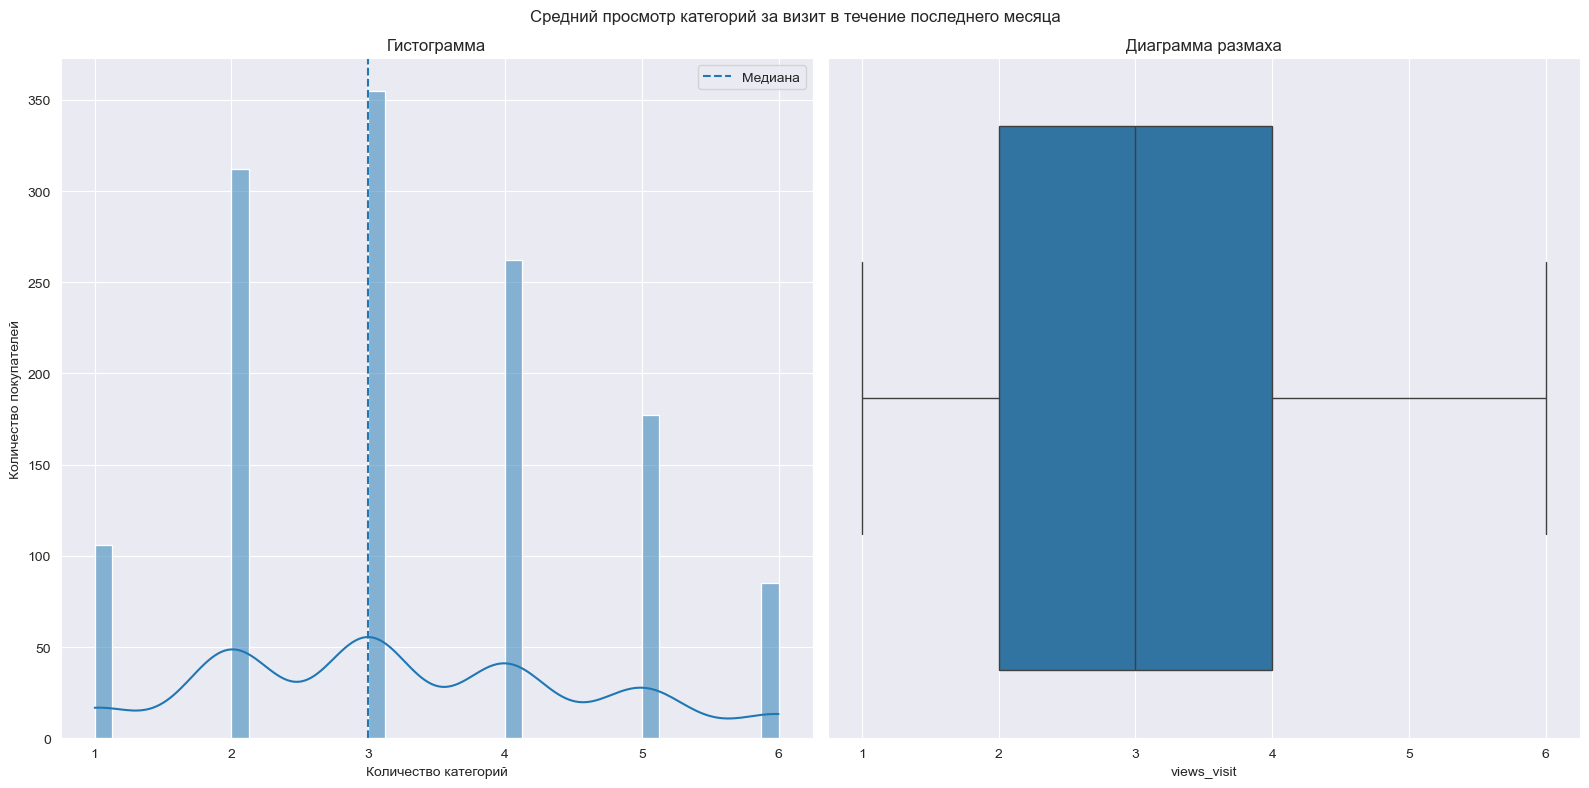

In [268]:
plot_hist_and_box(market, 
                  column='views_visit', 
                  axis_label='Количество категорий',
                  suptitle='Средний просмотр категорий за визит в течение последнего месяца'
                 )

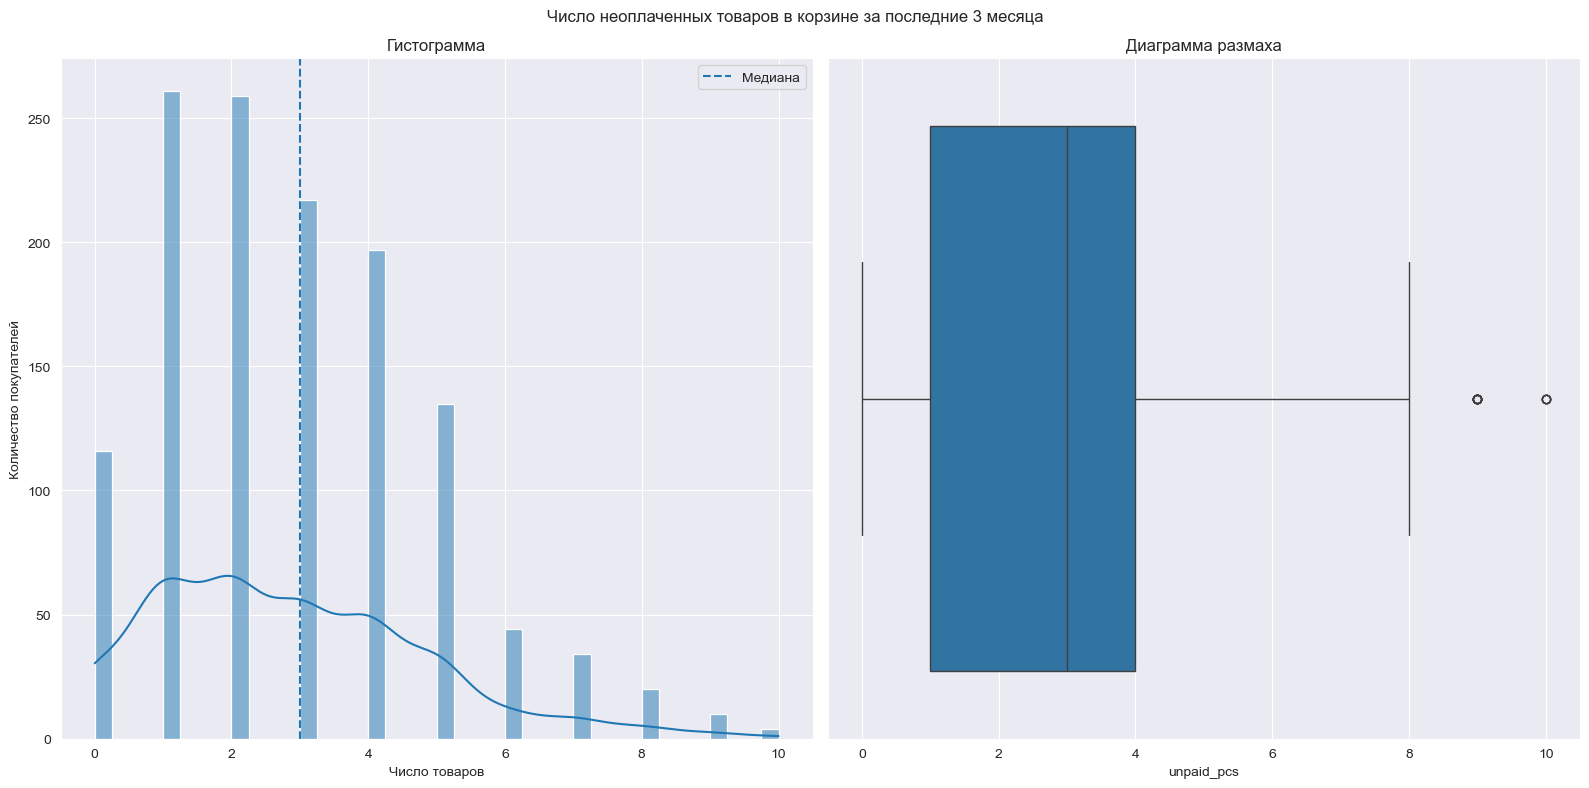

In [269]:
plot_hist_and_box(market, 
                  column='unpaid_pcs', 
                  axis_label='Число товаров',
                  suptitle='Число неоплаченных товаров в корзине за последние 3 месяца'
                 )

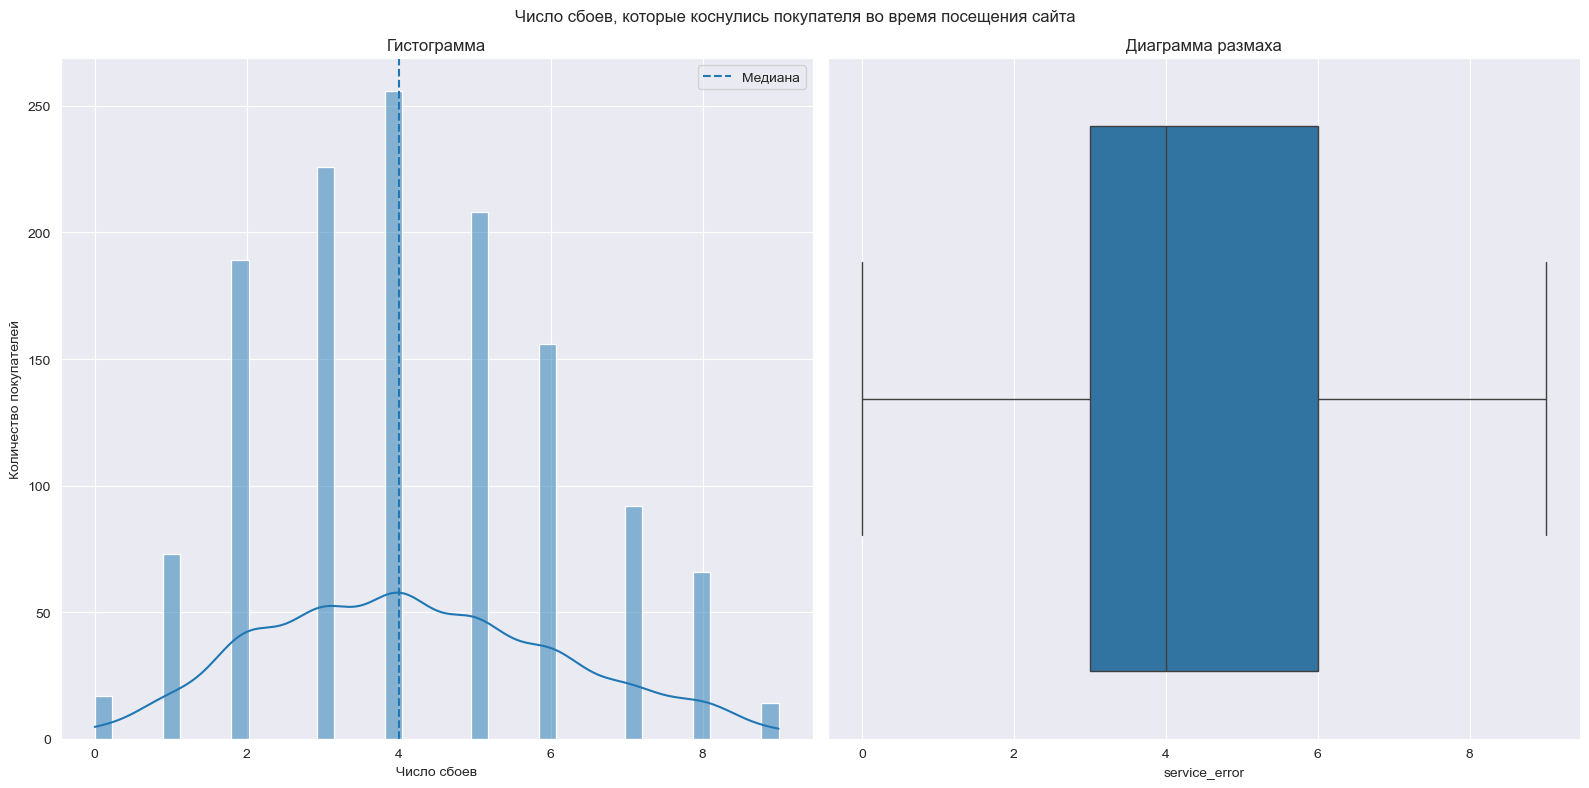

In [270]:
plot_hist_and_box(market, 
                  column='service_error', 
                  axis_label='Число сбоев',
                  suptitle='Число сбоев, которые коснулись покупателя во время посещения сайта'
                 )

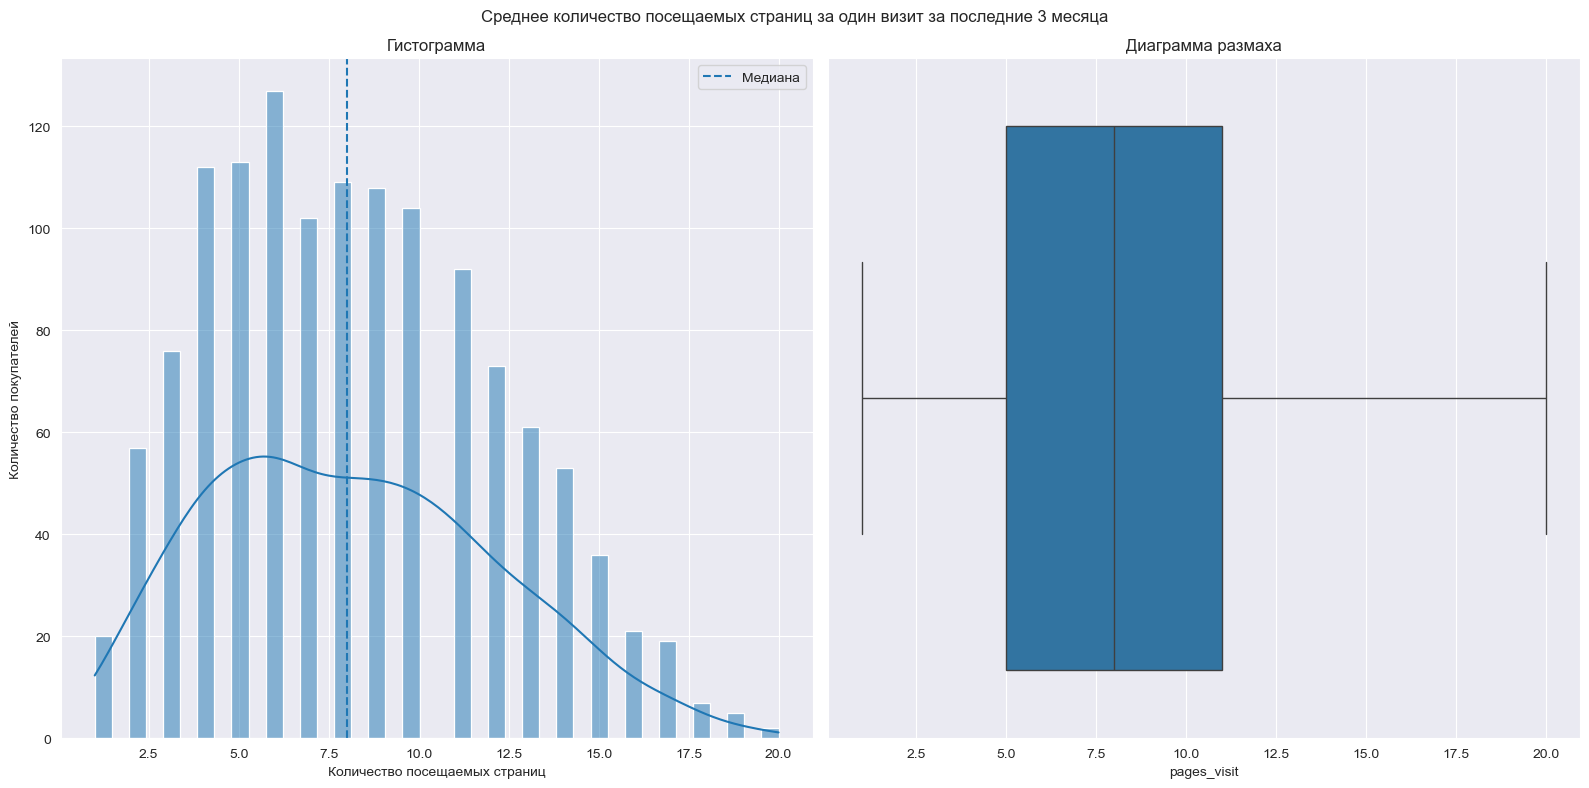

In [271]:
plot_hist_and_box(market, 
                  column='pages_visit', 
                  axis_label='Количество посещаемых страниц',
                  suptitle='Среднее количество посещаемых страниц за один визит за последние 3 месяца'
                 )

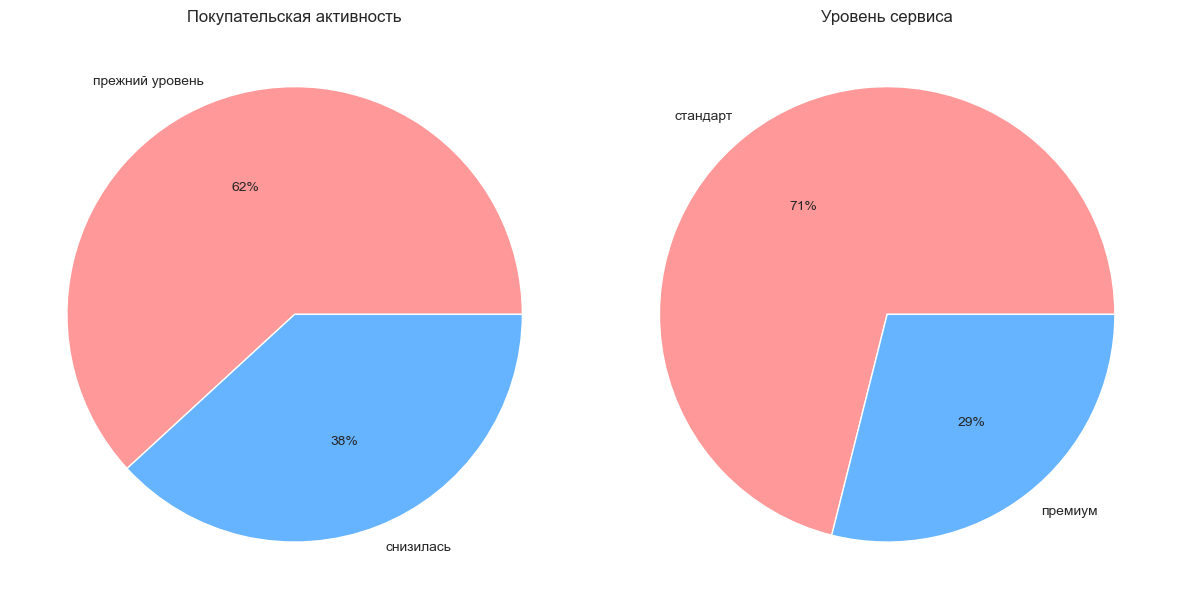

In [272]:
plot_two_pie_charts(market,
                      columns=['activity', 'type_service'],
                      titles=['Покупательская активность', 'Уровень сервиса']
                     )

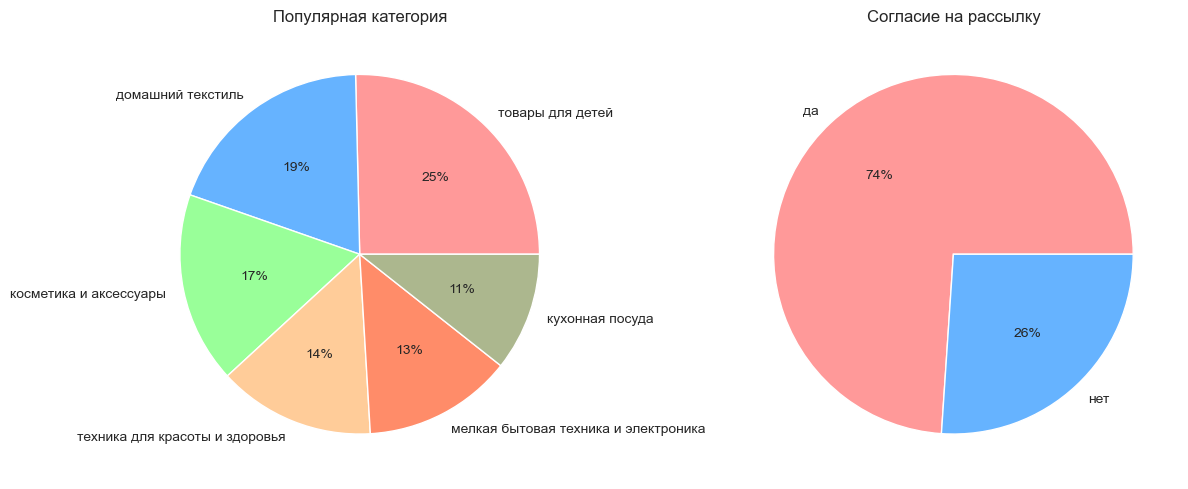

In [273]:
plot_two_pie_charts(market,
                      columns=['popular_category', 'reporting'],
                      titles=['Популярная категория', 'Согласие на рассылку']
                     )

In [274]:
mmoney.describe()

id    revenue
count   3,891.00   3,891.00
mean  215,998.99   5,033.72
std       374.48   1,768.47
min   215,349.00   2,758.70
25%   215,675.00   4,592.00
50%   215,999.00   4,959.00
75%   216,323.00   5,363.20
max   216,647.00 106,862.20

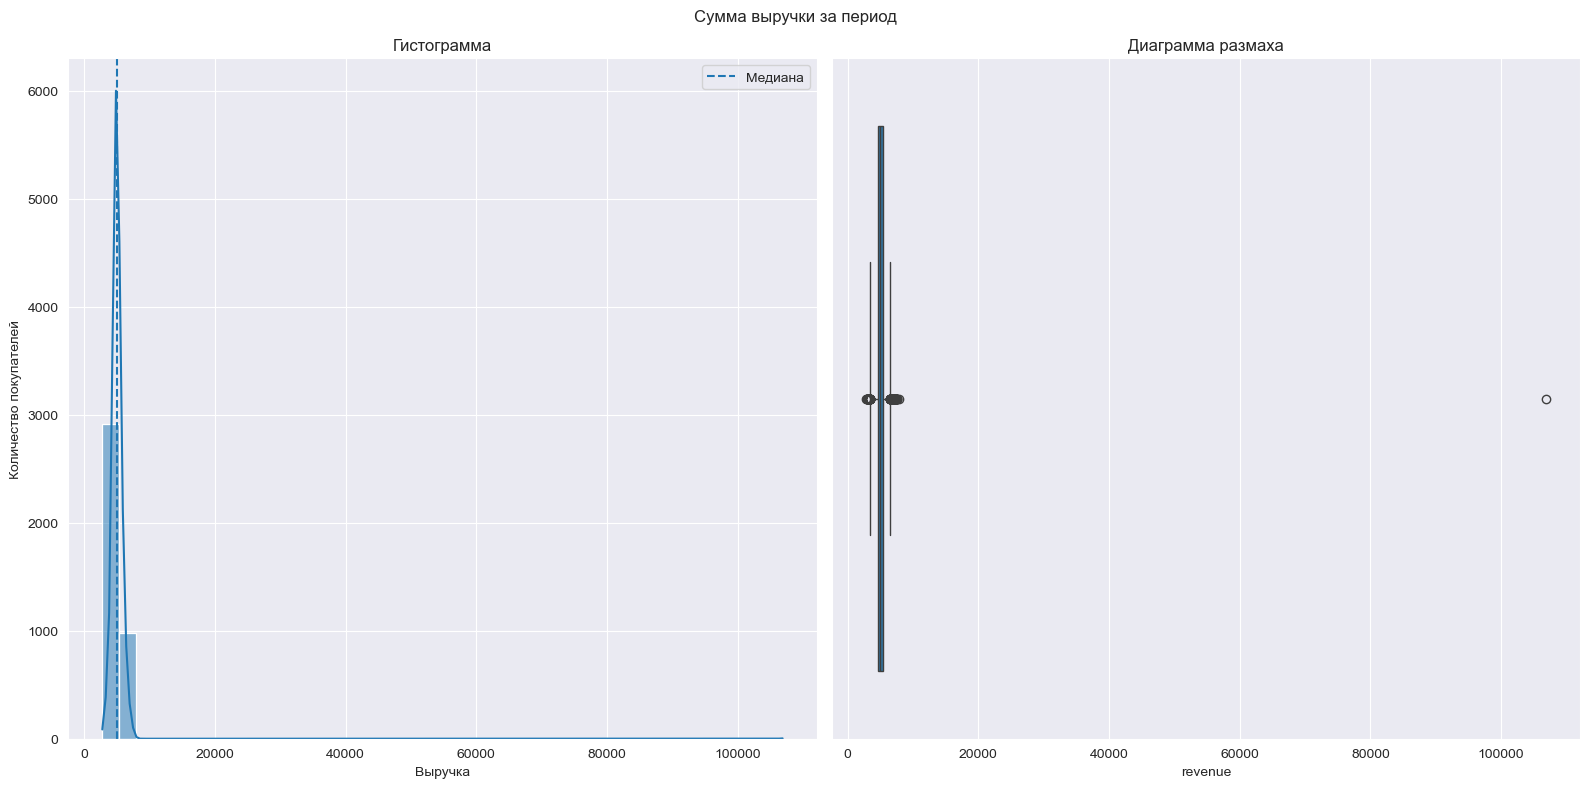

In [275]:
plot_hist_and_box(mmoney, 
                  column='revenue', 
                  axis_label='Выручка',
                  suptitle='Сумма выручки за период'
                 )

In [276]:
mmoney.query('revenue > 20000')

id         period    revenue
89  215380  текущий_месяц 106,862.20

In [277]:
# Удалим выброс из датафрейма
mmoney = mmoney.query('revenue < 20000')

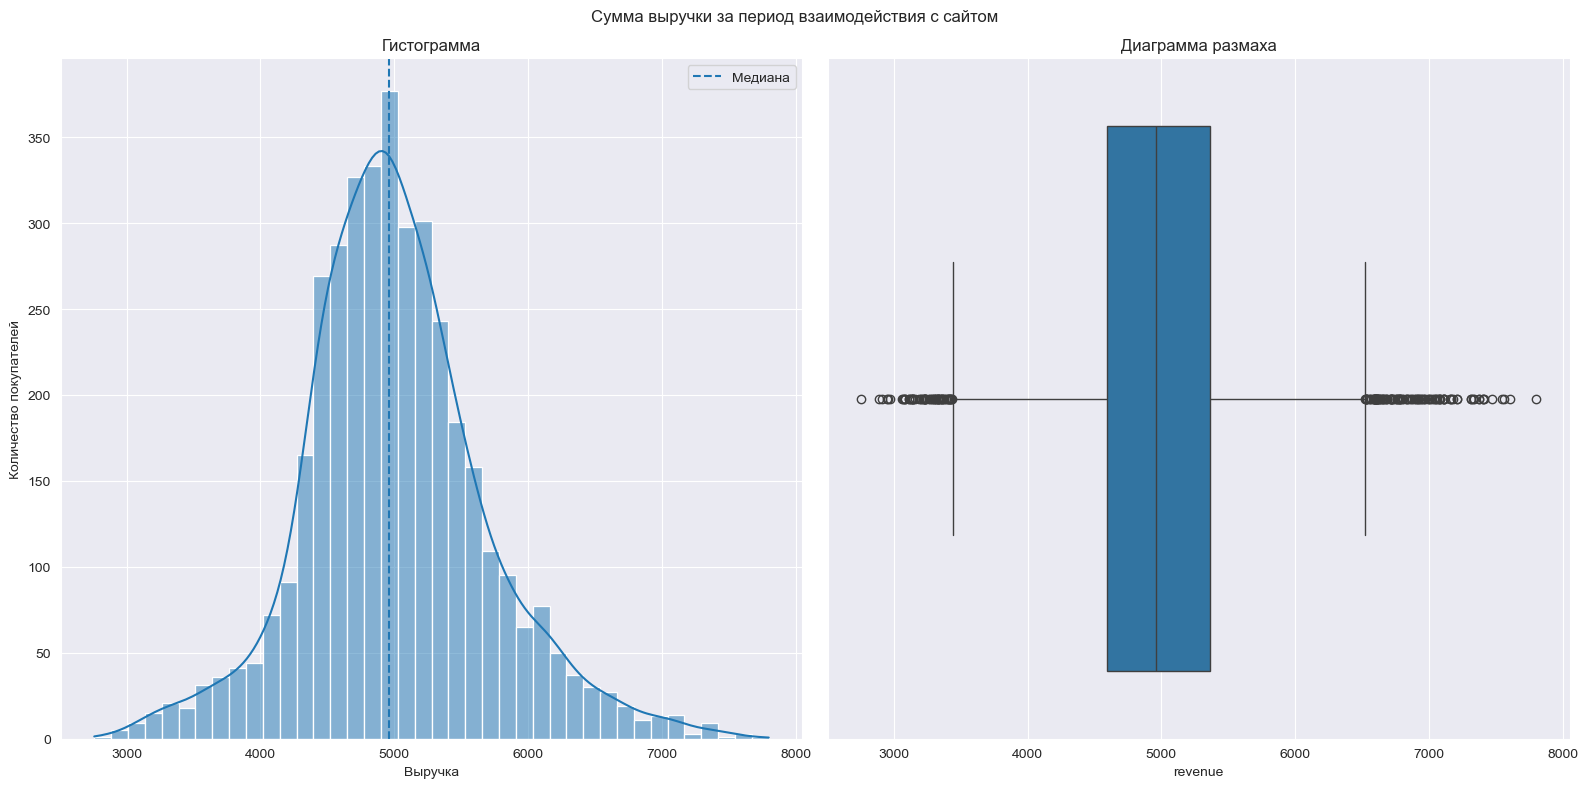

In [278]:
plot_hist_and_box(mmoney, 
                  column='revenue', 
                  axis_label='Выручка',
                  suptitle='Сумма выручки за период взаимодействия с сайтом'
                 )

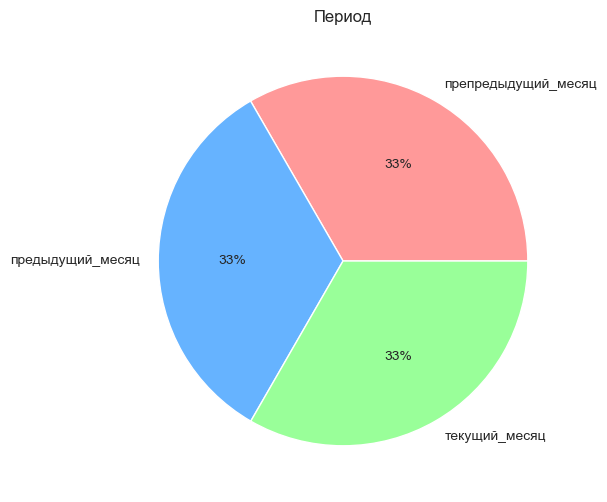

In [279]:
mmoney['period'].value_counts().plot(
    y = 'count', 
    kind = 'pie', 
    autopct='%1.0f%%', 
    title = 'Период', 
    colors = DEFAULT_PALETTE, 
    figsize = (12, 6),
    ylabel=''
)
plt.show()

In [280]:
mtime.describe()

id  minutes
count   2,594.00 2,594.00
mean  215,998.99    13.34
std       374.51     4.08
min   215,349.00     4.00
25%   215,675.00    10.00
50%   215,999.00    13.00
75%   216,323.00    16.00
max   216,647.00    23.00

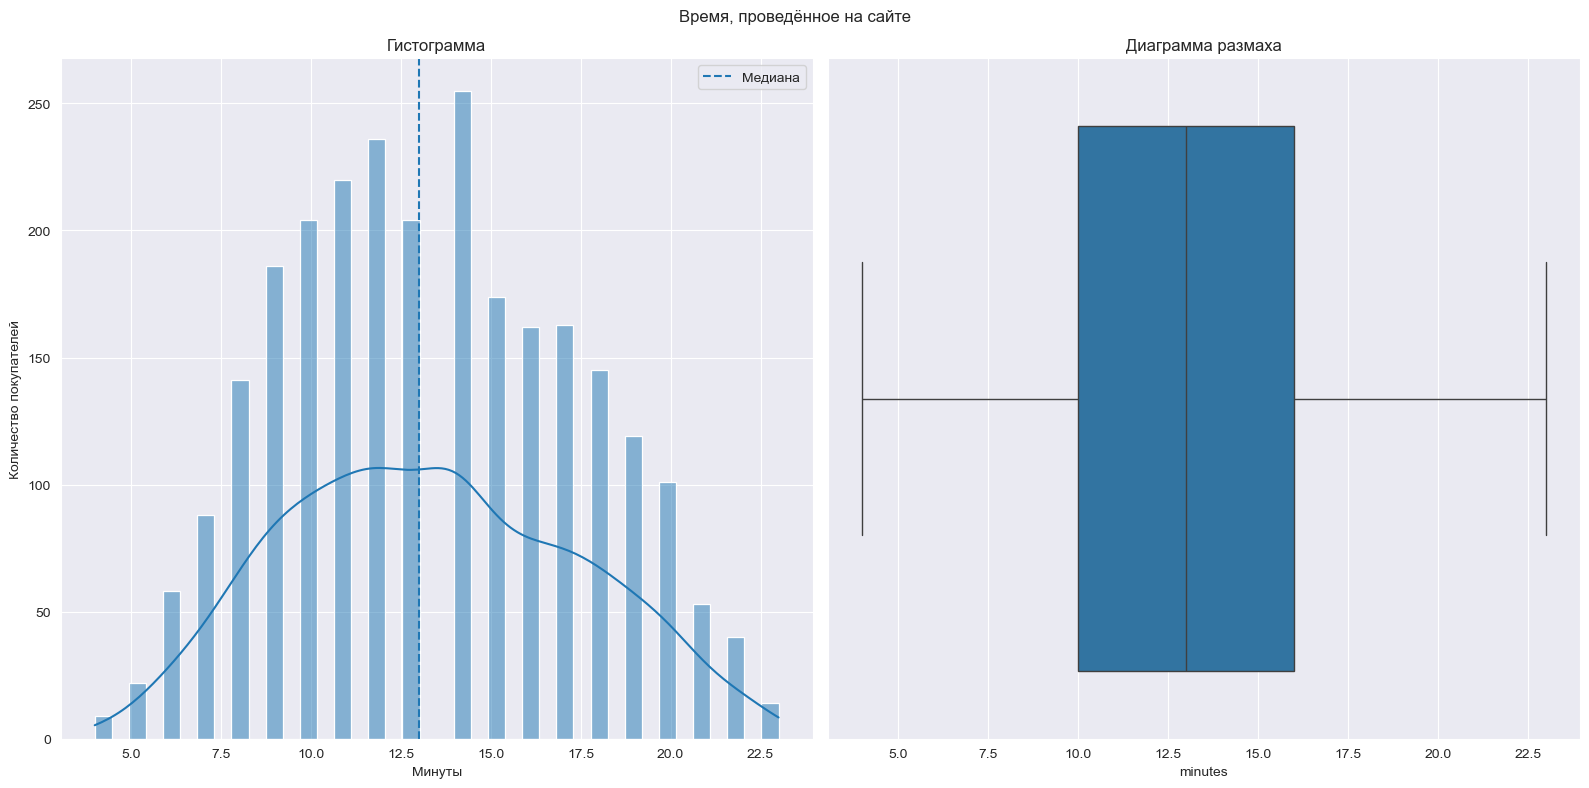

In [281]:
plot_hist_and_box(mtime, 
                  column='minutes', 
                  axis_label='Минуты',
                  suptitle='Время, проведённое на сайте'
                 )

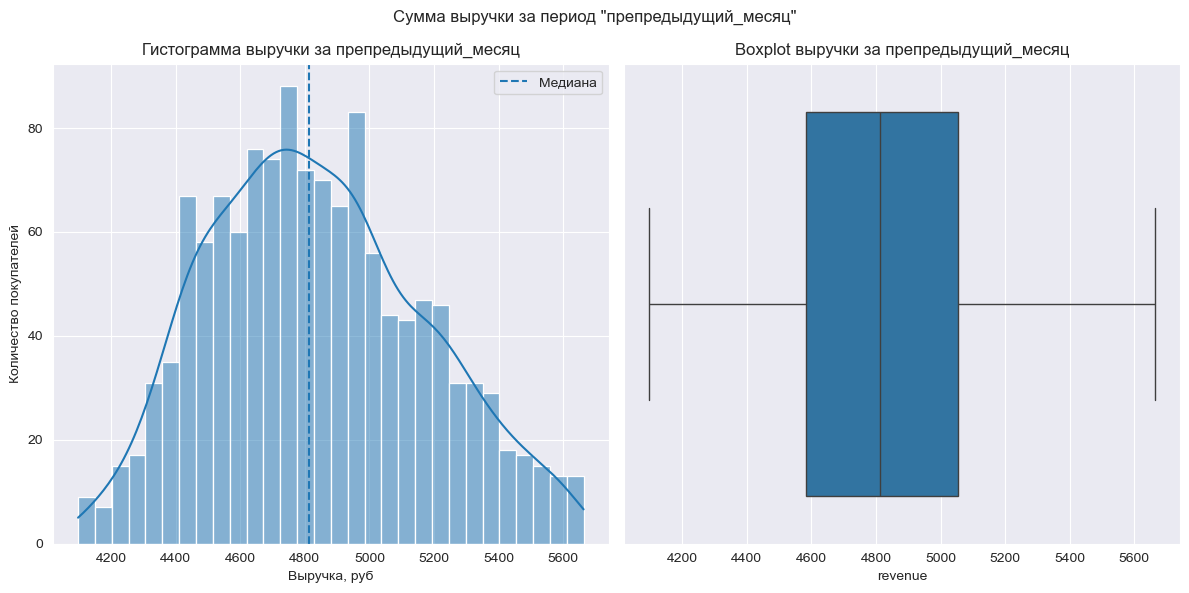

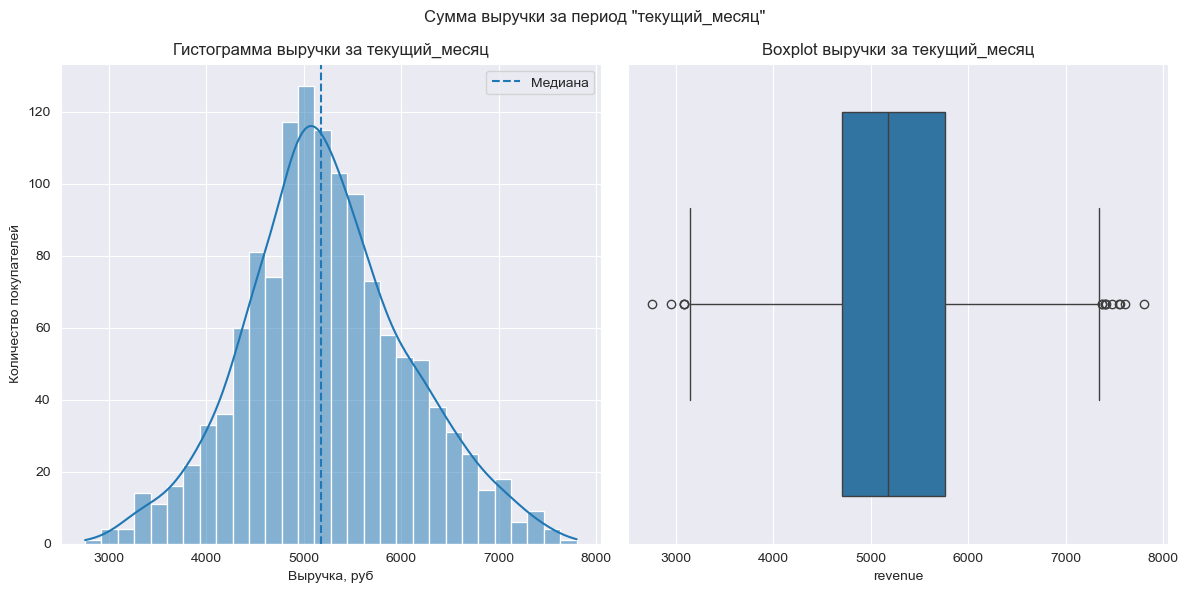

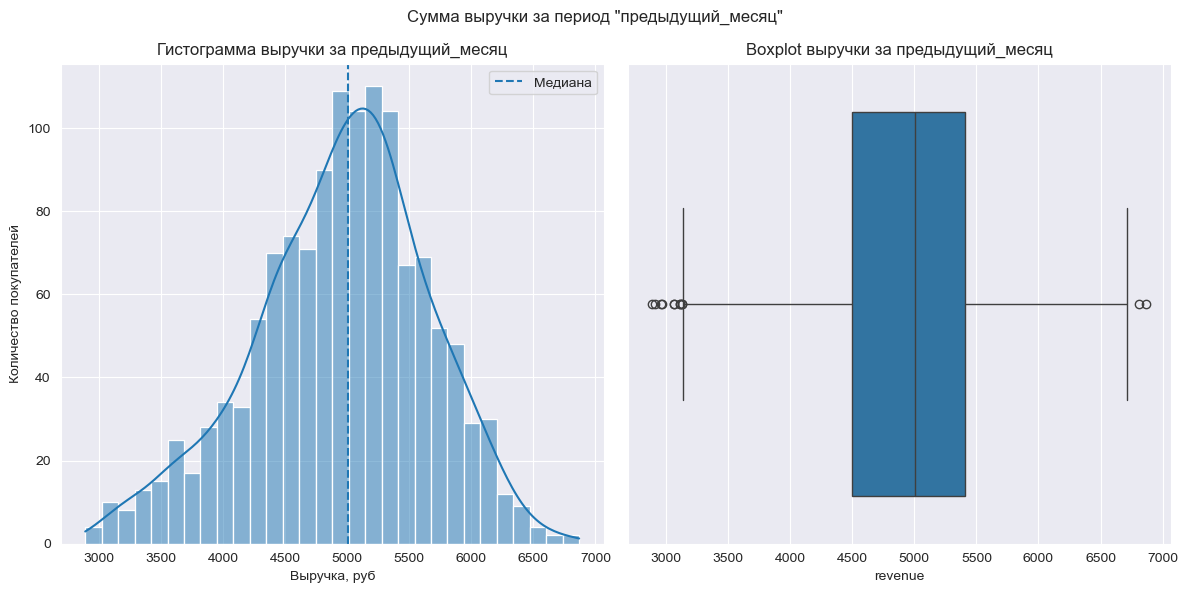

In [282]:
# Получаем список уникальных периодов в данных по выручке
periods = mmoney['period'].unique()

for p in periods:
    subset = mmoney[mmoney['period'] == p]
    plot_hist_and_box(
        subset,
        column='revenue',
        bins=30,
        figsize=(12, 6),
        hist_title=f'Гистограмма выручки за {p}',
        box_title=f'Boxplot выручки за {p}',
        axis_label='Выручка, руб',
        suptitle=f'Сумма выручки за период "{p}"'
    )

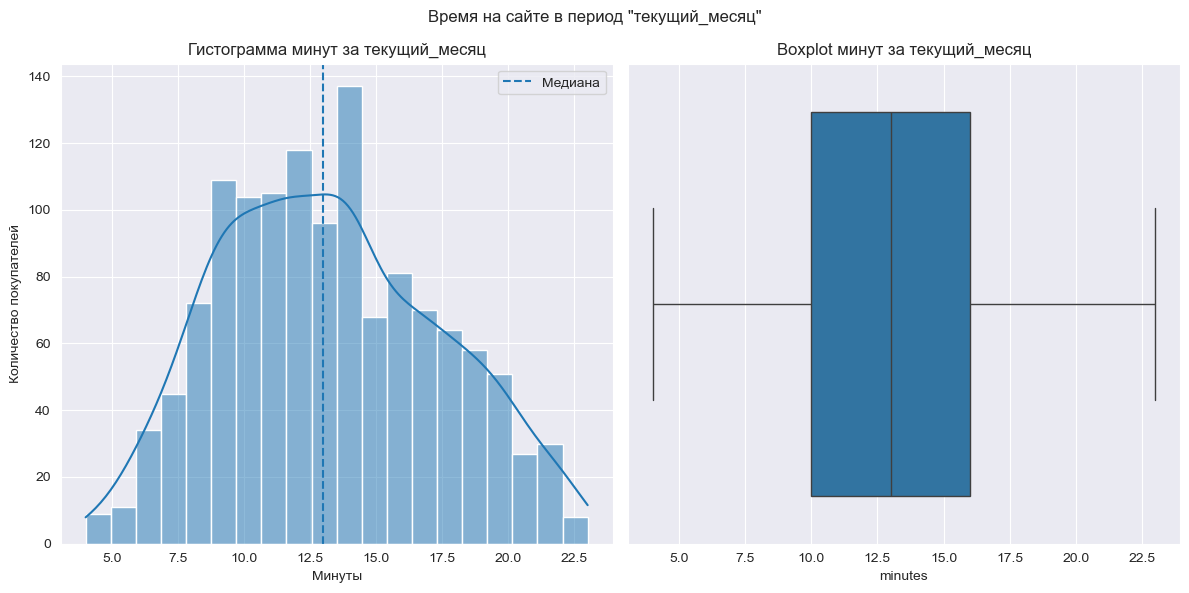

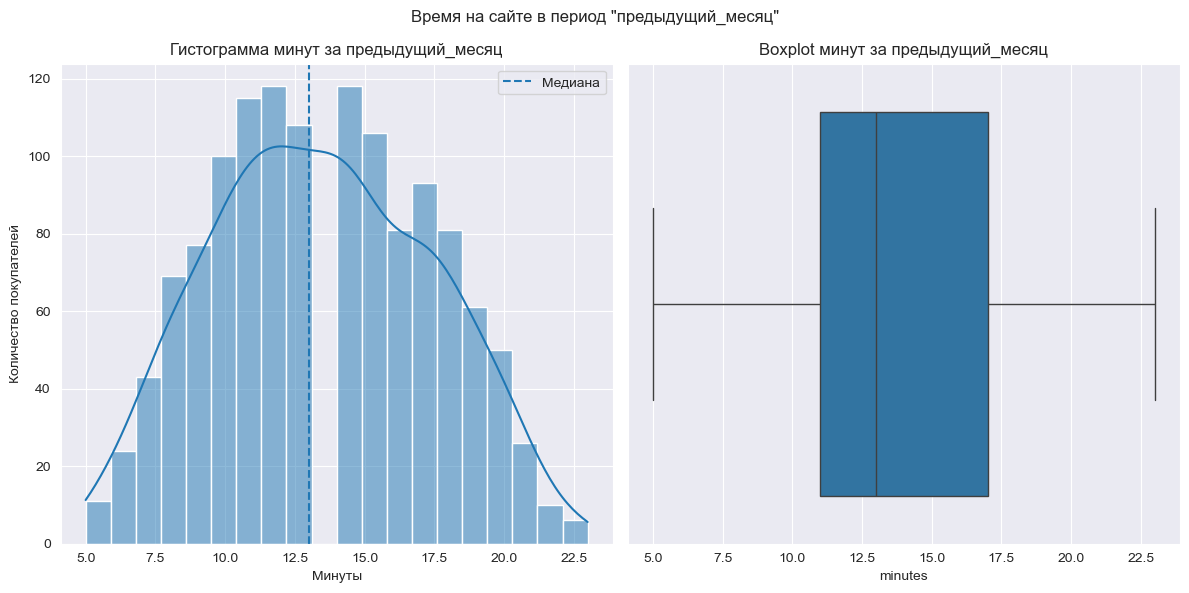

In [283]:
# Получаем список уникальных периодов
periods = mtime['period'].unique()

for p in periods:
    subset = mtime[mtime['period'] == p]
    plot_hist_and_box(
        subset,
        column='minutes',
        bins=20,
        figsize=(12, 6),
        hist_title=f'Гистограмма минут за {p}',
        box_title=f'Boxplot минут за {p}',
        axis_label='Минуты',
        suptitle=f'Время на сайте в период "{p}"'
    )

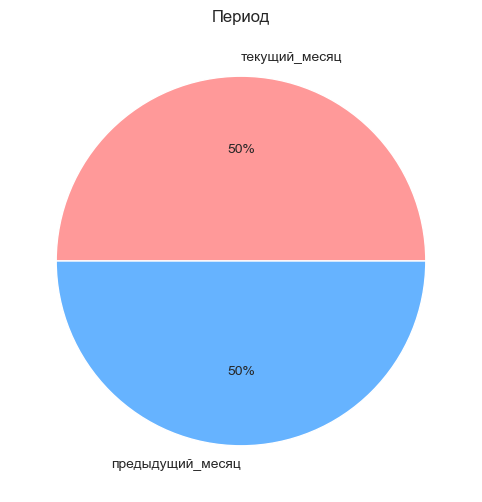

In [284]:
mtime['period'].value_counts().plot(
    y = 'count', 
    kind = 'pie', 
    autopct='%1.0f%%', 
    title = 'Период', 
    colors = DEFAULT_PALETTE, 
    figsize = (12, 6),
    ylabel=''
)
plt.show()

In [285]:
money.describe()

id   profit
count   1,297.00 1,297.00
mean  215,998.99     4.00
std       374.58     1.01
min   215,349.00     0.86
25%   215,675.00     3.30
50%   215,999.00     4.04
75%   216,323.00     4.67
max   216,647.00     7.43

При средней выручке с покупателя порядка 5000 руб. прибыль не может изменяться единицами руб., делаем вывод, что прибыль в данных у нас выражается в %

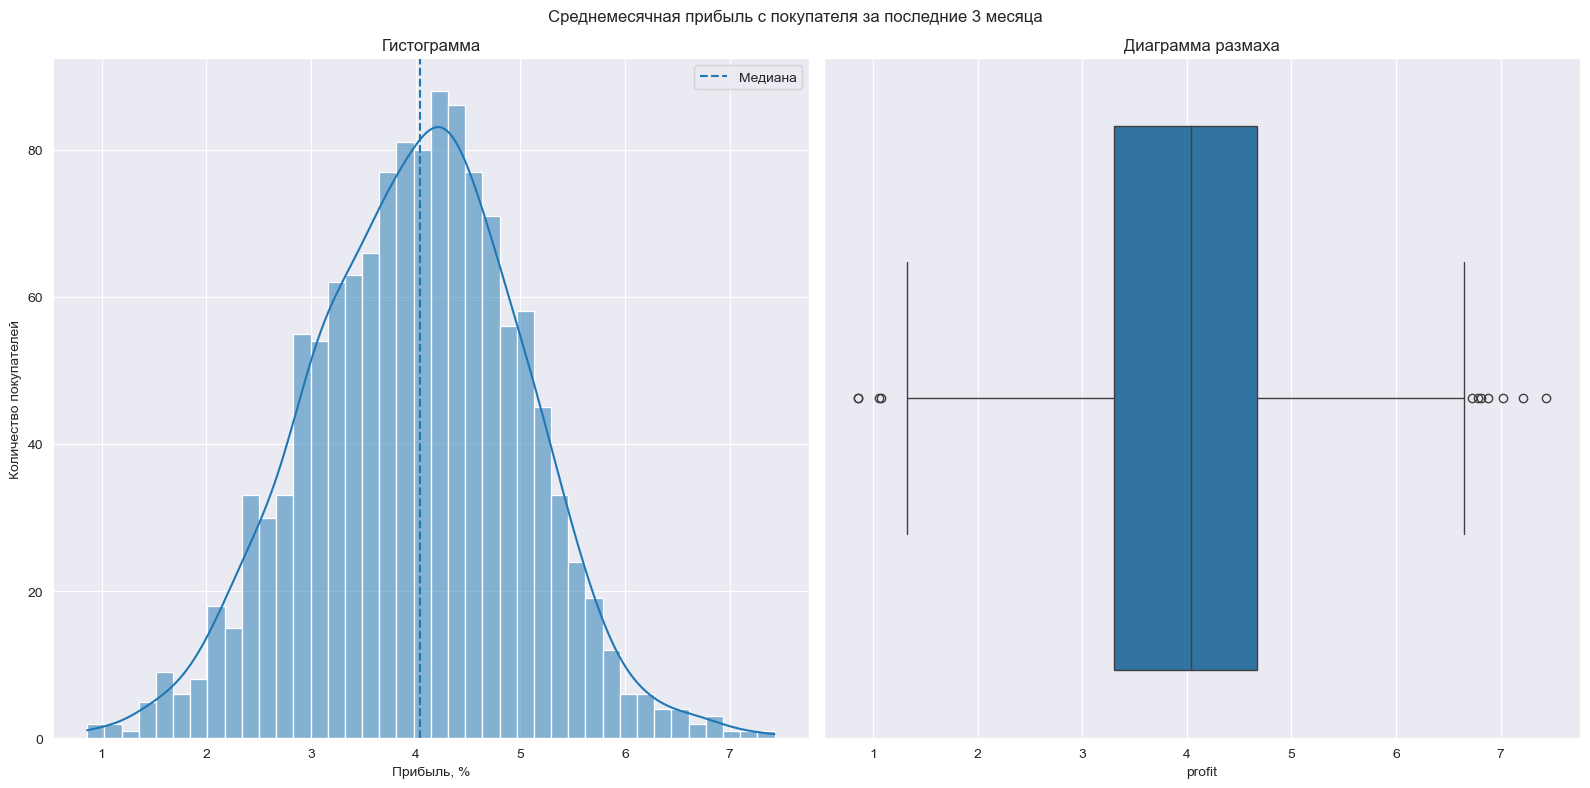

In [286]:
plot_hist_and_box(money, 
                  column='profit', 
                  axis_label='Прибыль, %',
                  suptitle='Среднемесячная прибыль с покупателя за последние 3 месяца'
                 )

<div style="background-color:aquamarine; color:#black; text-align:left; padding:2%">
<font size="4", color= "black"><b>Результат:</b> в рамках данного этапа мы выполнили исследовательский анализ данных. При этом для анализа были отобраны только клиенты с покупательской активностью не менее трёх месяцев, то есть те, которые что-либо покупали в этот период. Мы вывели графики для всех количественных и категориальных признаков по каждому датафрейму и проанализировали минимальные, максимальные, средние и медианные значения для каждого из количественных признаков. Изучили соотношения для категориальных признаков. Был обнаужен и удален один выброс в данных по выручке.
</font>

## Объединение таблиц

<div style="background-color:lavender; color:#black; text-align:left; padding:2%">
<font size="4", color= "black">Объединим таблицы market_file.csv, market_money.csv, market_time.csv</font>

In [287]:
df1 = (
    mmoney
    .pivot(index='id', columns='period', values='revenue')
    .reset_index()
)
df1.columns.name = None
display(df1)

id  предыдущий_месяц  препредыдущий_месяц  текущий_месяц
0     215349          5,216.00             4,472.00       4,971.60
1     215350          5,457.50             4,826.00       5,058.40
2     215351          6,158.00             4,793.00       6,610.40
3     215352          5,807.50             4,594.00       5,872.50
4     215353          4,738.50             5,124.00       5,388.50
...      ...               ...                  ...            ...
1292  216643          3,664.00             4,704.00       4,741.70
1293  216644          4,729.00             5,299.00       5,353.00
1294  216645          5,160.00             5,334.00       5,139.20
1295  216646          4,923.00             4,725.00       5,224.60
1296  216647          4,720.00             5,183.00       4,448.30

[1297 rows x 4 columns]

In [288]:
df1 = df1.rename(columns={
    'текущий_месяц': 'current_rev',
    'предыдущий_месяц': 'pred_rev',
    'препредыдущий_месяц': 'predpr_rev'
})

print(df1.shape)
display(df1.head())

(1297, 4)


id  pred_rev  predpr_rev  current_rev
0  215349  5,216.00    4,472.00     4,971.60
1  215350  5,457.50    4,826.00     5,058.40
2  215351  6,158.00    4,793.00     6,610.40
3  215352  5,807.50    4,594.00     5,872.50
4  215353  4,738.50    5,124.00     5,388.50

In [289]:
df2 = (
    mtime
    .pivot(index='id', columns='period', values='minutes')
    .reset_index()
)
df2.columns.name = None
display(df2)

id  предыдущий_месяц  текущий_месяц
0     215349                12             10
1     215350                 8             13
2     215351                11             13
3     215352                 8             11
4     215353                10             10
...      ...               ...            ...
1292  216643                14              7
1293  216644                12             11
1294  216645                12             18
1295  216646                18              7
1296  216647                15             10

[1297 rows x 3 columns]

In [290]:
df2 = df2.rename(columns={
    'текущий_месяц': 'current_min',
    'предыдущий_месяц': 'pred_min'
})

print(df2.shape)
display(df2.head())

(1297, 3)


id  pred_min  current_min
0  215349        12           10
1  215350         8           13
2  215351        11           13
3  215352         8           11
4  215353        10           10

In [291]:
data = (
    market
    .merge(df1, on='id', how='inner')
    .merge(df2, on='id', how='inner')
)
data.set_index('id', inplace=True)

In [292]:
print(data.shape)
display(data.head())
data.info()

(1297, 17)


activity type_service reporting  active_6m  active_current  duration  \
id                                                                              
215349  снизилась      премиум        да       4.40               4       819   
215350  снизилась     стандарт       нет       4.90               3       539   
215351  снизилась     стандарт        да       3.20               5       896   
215352  снизилась     стандарт       нет       5.10               3      1064   
215353  снизилась     стандарт        да       3.30               4       762   

        promo_purchases   popular_category  views_visit  unpaid_pcs  \
id                                                                    
215349             0.75   товары для детей            4           4   
215350             0.14  домашний текстиль            5           2   
215351             0.99   товары для детей            5           0   
215352             0.94   товары для детей            3           2   
215353             0.26  домашний текстиль            4           1   

        service_error  pages_visit  pred_rev  predpr_rev  current_rev  \
id                                                                      
215349              2            5  5,216.00    4,472.00     4,971.60   
215350              1            5  5,457.50    4,826.00     5,058.40   
215351              6            4  6,158.00    4,793.00     6,610.40   
215352              3            2  5,807.50    4,594.00     5,872.50   
215353              1            4  4,738.50    5,124.00     5,388.50   

        pred_min  current_min  
id                             
215349        12           10  
215350         8           13  
215351        11           13  
215352         8           11  
215353        10           10

<class 'pandas.core.frame.DataFrame'>
Index: 1297 entries, 215349 to 216647
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   activity          1297 non-null   object 
 1   type_service      1297 non-null   object 
 2   reporting         1297 non-null   object 
 3   active_6m         1297 non-null   float64
 4   active_current    1297 non-null   int64  
 5   duration          1297 non-null   int64  
 6   promo_purchases   1297 non-null   float64
 7   popular_category  1297 non-null   object 
 8   views_visit       1297 non-null   int64  
 9   unpaid_pcs        1297 non-null   int64  
 10  service_error     1297 non-null   int64  
 11  pages_visit       1297 non-null   int64  
 12  pred_rev          1297 non-null   float64
 13  predpr_rev        1297 non-null   float64
 14  current_rev       1296 non-null   float64
 15  pred_min          1297 non-null   int64  
 16  current_min       1297 non-null   int64 

In [293]:
dtype_map = {
    # числовые столбцы → float32
    'active_6m': 'float32',
    'promo_purchases': 'float32',
    'pred_rev': 'float32',
    'predpr_rev': 'float32',
    'current_rev': 'float32',
    # целочисленные → int32
    'active_current': 'int32',
    'duration': 'int32',
    'views_visit': 'int32',
    'unpaid_pcs': 'int32',
    'service_error': 'int32',
    'pages_visit': 'int32',
    'pred_min': 'int32',
    'current_min':'int32', 
    # категориальные → category
    'activity': 'category',
    'type_service':'category',
    'reporting': 'category',
    'popular_category': 'category'
}

data = data.astype(dtype_map)

In [294]:
data = data.dropna()
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1296 entries, 215349 to 216647
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   activity          1296 non-null   category
 1   type_service      1296 non-null   category
 2   reporting         1296 non-null   category
 3   active_6m         1296 non-null   float32 
 4   active_current    1296 non-null   int32   
 5   duration          1296 non-null   int32   
 6   promo_purchases   1296 non-null   float32 
 7   popular_category  1296 non-null   category
 8   views_visit       1296 non-null   int32   
 9   unpaid_pcs        1296 non-null   int32   
 10  service_error     1296 non-null   int32   
 11  pages_visit       1296 non-null   int32   
 12  pred_rev          1296 non-null   float32 
 13  predpr_rev        1296 non-null   float32 
 14  current_rev       1296 non-null   float32 
 15  pred_min          1296 non-null   int32   
 16  current_min       1296

<div style="background-color:aquamarine; color:#black; text-align:left; padding:2%">
<font size="4", color= "black"><b>Результат:</b> таблицы корректно объединены в один датафрейм (data), типы данных изменены для экономии памяти, ускорения обучения и упрощения дальнейшего кодирования</font>

## Корреляционный анализ

<div style="background-color:lavender; color:#black; text-align:left; padding:2%">
<font size="4", color= "black">Проведем корреляционный анализ признаков в количественной шкале в итоговой таблице для моделирования</font>

In [295]:
data.phik_matrix().style.background_gradient(cmap ='coolwarm')

interval columns not set, guessing: ['active_6m', 'active_current', 'duration', 'promo_purchases', 'views_visit', 'unpaid_pcs', 'service_error', 'pages_visit', 'pred_rev', 'predpr_rev', 'current_rev', 'pred_min', 'current_min']


In [296]:
interval_cols = [
    'active_6m', 'active_current', 'duration',
    'promo_purchases', 'views_visit', 'unpaid_pcs',
    'service_error', 'pages_visit',
    'pred_rev', 'predpr_rev', 'current_rev',
    'pred_min', 'current_min'
]

# Считаем phik-матрицу, передавая список interval_cols и желаемое число бинов:
full_corr = data.phik_matrix(
    interval_cols=interval_cols,
    bins=20
)

# Оставляем только нужные строки и столбцы:
phik_interval = full_corr.loc[interval_cols, interval_cols]

# Визуализируем градиентом:
phik_interval.style.background_gradient(cmap='coolwarm')

In [297]:
X = data[interval_cols].dropna().reset_index(drop=True)
vif_dict = {}

for col in interval_cols:
    y = X[col]
    X_other = X.drop(columns=[col])
    
    model = LinearRegression().fit(X_other, y)
    r2 = model.score(X_other, y)
    
    vif_dict[col] = 1 / (1 - r2)

vif_df = (
    pd.DataFrame.from_dict(vif_dict, orient='index', columns=['VIF'])
      .sort_values('VIF', ascending=False)
)
print(vif_df)

                 VIF
pred_rev        4.26
current_rev     3.90
predpr_rev      1.61
pred_min        1.53
pages_visit     1.42
current_min     1.32
active_6m       1.22
unpaid_pcs      1.20
promo_purchases 1.19
views_visit     1.18
duration        1.10
service_error   1.08
active_current  1.04


VIF измеряет, насколько сильно каждый признак скоррелирован с остальными:

- VIF = 1 означает, что нет никакой линейной связи с другими признаками.
- VIF от 1 до ~5 — признак имеет низкую или умеренную мультиколлинеарность, обычно это не критично.
- VIF > 5 (иногда порог берут 10) — признак сильно коррелирован с остальными, что может исказить оценки модели.

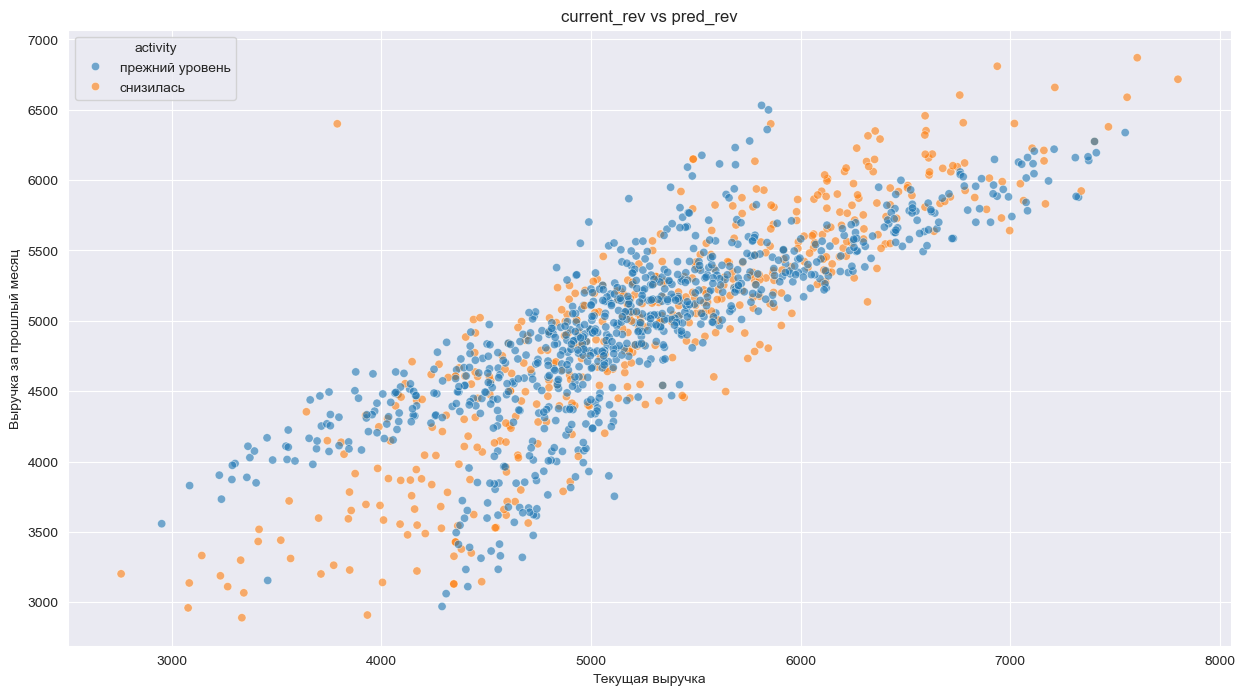

In [298]:
plt.figure(figsize=(15, 8))
sns.scatterplot(
    data=data, 
    x='current_rev', 
    y='pred_rev',
    hue='activity',
    alpha=0.6
)
plt.title('current_rev vs pred_rev')
plt.xlabel('Текущая выручка')
plt.ylabel('Выручка за прошлый месяц')
plt.show()

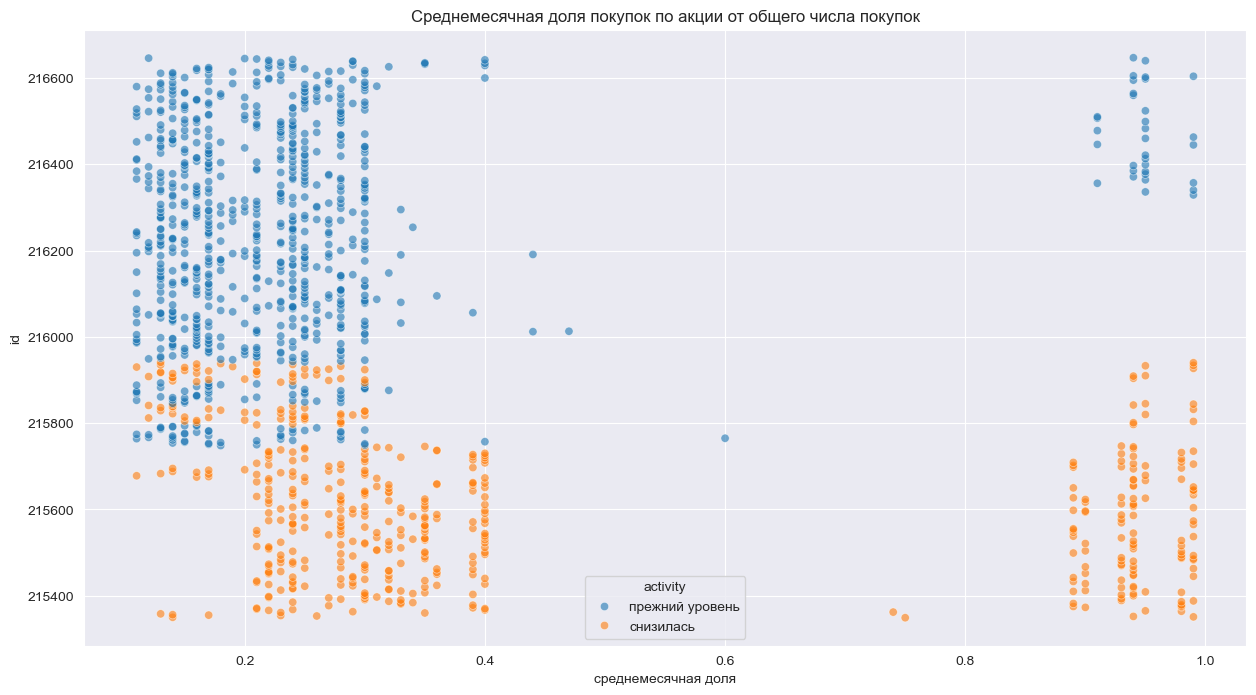

In [299]:
plt.figure(figsize=(15, 8))
sns.scatterplot(
    data=data, 
    x='promo_purchases', 
    y='id',
    hue='activity',
    alpha=0.6
)
plt.title('Cреднемесячная доля покупок по акции от общего числа покупок')
plt.xlabel('среднемесячная доля')
plt.ylabel('id')
plt.show()

<div style="background-color:aquamarine; color:#black; text-align:left; padding:2%">
<font size="4", color= "black"><b>Результат:</b> Признаки `pred_rev` (выручка предыдущего месяца) и `current_rev` (выручка текущего месяца) - мультиколлинеарны (значение в диапазоне 0.8–0.9). Но для нас важны оба этих признака, поэтому оставим их, а в дальнейшем посчитаем суммарную выручку и будем работать с ней.
    
Посмотрев scatter_plot между id и акционными покупками/таргетом мы заметили, что покупки по акции совершали в основном новые покупатели и при этом их покупательская активность не снижается.

Если посмотреть разницу между выручками (предыдущей и текущей), и нанести их на  scatter_plot, в разбивке по таргету можно увидеть, что имеется сильная линейная зависимость: выручка прошлого месяца (pred_rev) отлично предсказывает выручку текущего месяца (current_rev). В выборке реально существуют два сегмента клиентов с чуть разными зависимостями:
- Стабильные клиенты (синие) сохраняют примерно тот же уровень выручки от месяца к месяцу.
- Клиенты с пониженной активностью (оранжевые) показывают «сдвиг» вниз: их прошлые продажи ниже современных для той же группы по текущей выручке </font>

## Использование пайплайнов

<div style="background-color:lavender; color:#black; text-align:left; padding:2%">
<font size="4", color= "black">6.1 Во время подготовки данных используем ColumnTransformer. Количественные и категориальные признаки обработаем в пайплайне раздельно. Для кодирования категориальных признаков используем как минимум два кодировщика, для масштабирования количественных — как минимум два скейлера.</font>

In [300]:
X = data.drop(['activity'], axis=1)
y = data['activity']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    random_state = RANDOM_STATE,
    stratify=y
)

ohe_columns = [
    'type_service',
    'popular_category'
]
ord_columns = [
    'reporting'
]
num_columns = [
    'active_6m', 'active_current', 'duration', 'promo_purchases',
    'views_visit', 'unpaid_pcs', 'service_error', 'pages_visit',
    'pred_rev', 'predpr_rev', 'current_rev', 'pred_min', 'current_min'
]

In [301]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [302]:
mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label mapping:", mapping)

Label mapping: {'прежний уровень': 0, 'снизилась': 1}


In [303]:
if mapping.get('снизилась') == 0:
    # можно инвертировать
    y_train_enc = 1 - y_train
    y_test_enc  = 1 - y_test
    mapping = {k: 1 - v for k, v in mapping.items()}
print("Inverted mapping:", mapping)

Inverted mapping: {'прежний уровень': 0, 'снизилась': 1}


In [304]:
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='error', sparse_output =False)
        )
    ]
) 

In [305]:
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',  
            OrdinalEncoder(
                categories=[
                    ['да', 'нет']
                ], 
                handle_unknown='error'
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

In [306]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ],
    remainder='passthrough'
)

In [307]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

<div style="background-color:lavender; color:#black; text-align:left; padding:2%">
<font size="4", color= "black">6.2. Обучим пять моделей: KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression(),SVC() и RandomForestClassifier. Для каждой из них подберем как минимум один гиперпараметр.</font>

In [308]:
param_grid = [
    # словарь для модели KNeighborsClassifier()
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 10),
        'models__weights': ['uniform', 'distance'],
        'models__algorithm': ['auto','ball_tree','kd_tree'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 10),
        'models__max_features': range(2, 10),
        'models__class_weight': ['balanced', None],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    
    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE,
            solver='liblinear',
            penalty='l1'
        )],
        'models__C': range(1, 10),
        'models__class_weight': ['balanced', None],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    
    # словарь для модели SVC
    { 
        'models': [SVC(random_state=RANDOM_STATE, probability= True)],
        'models__C': range(1, 10),
        'models__kernel': ['rbf', 'linear', 'sigmoid'],
        'models__class_weight': ['balanced', None],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [RandomForestClassifier(random_state=RANDOM_STATE)],
        'models__n_estimators': [100, 200],
        'models__max_depth': [None, 5, 10],
        'models__min_samples_split': [2, 5],
        'models__class_weight': ['balanced', None],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

<div style="background-color:lavender; color:#black; text-align:left; padding:2%">
<font size="4", color= "black">6.3. При прогнозе активности покупателей у нас всего два класса, поэтому задача бинарная и для нее вполне подойдет метрика ROC_AUC. Потому что:
    
- не зависит от порога,
- хорошо отражает качество ранжирования положительного/отрицательного классов,
- устойчива к умеренному дисбалансу.</font>

In [309]:
%%time

randomized_search = RandomizedSearchCV(
    estimator=pipe_final,
    param_distributions=param_grid,
    cv=5,
    scoring={
        'roc_auc':    'roc_auc',
        'precision':  'precision',
        'recall':     'recall',
        'f1':         'f1'
    },
    refit='roc_auc',                 # по этой метрике будет подбираться лучшая модель
    verbose=3,                       # подробный вывод процесса
    random_state=RANDOM_STATE,
    n_jobs=-1
)

randomized_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 3/5] END models=DecisionTreeClassifier(random_state=42), models__class_weight=balanced, models__max_depth=4, models__max_features=3, preprocessor__num=MinMaxScaler(); f1: (test=0.629) precision: (test=0.652) recall: (test=0.608) roc_auc: (test=0.728) total time=   0.0s
[CV 5/5] END models=DecisionTreeClassifier(random_state=42), models__class_weight=balanced, models__max_depth=4, models__max_features=3, preprocessor__num=MinMaxScaler(); f1: (test=0.676) precision: (test=0.723) recall: (test=0.635) roc_auc: (test=0.762) total time=   0.0s
[CV 4/5] END models=DecisionTreeClassifier(random_state=42), models__class_weight=balanced, models__max_depth=8, models__max_features=5, preprocessor__num=passthrough; f1: (test=0.734) precision: (test=0.785) recall: (test=0.689) roc_auc: (test=0.790) total time=   0.0s
[CV 1/5] END models=DecisionTreeClassifier(random_state=42), models__class_weight=balanced, models__max_depth=4, models_

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              sparse_output=False))]),
                                                                               ['type_service',
                                                                                'popular_category']),
                                                                              ('ord',
                                                                               Pipeline(steps=[('simpleImputer_before_or...
                                        {'models': [RandomForestClassifier(random_state=42)],
                                         'models__class_weight': ['balanced',
                                                                  None],
                                         'models__max_depth': [None, 5, 10],
                                         'models__min_samples_split': [2, 5],
                                         'models__n_estimators': [100, 200],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42, refit='roc_auc',
                   scoring={'f1': 'f1', 'precision': 'precision',
                            'recall': 'recall', 'roc_auc': 'roc_auc'},
                   verbose=3)

In [310]:
results = pd.DataFrame(randomized_search.cv_results_)

print("Все колонки в cv_results_:\n", list(results.columns))

mean_cols = [c for c in results.columns if c.startswith('mean_test')]
rank_cols = [c for c in results.columns if c.startswith('rank_test')]

print("\nmean-колонки:\n", mean_cols)
print("\nrank-колонки:\n", rank_cols)

table = results[['params'] + rank_cols + mean_cols]
table_sorted = table.sort_values(rank_cols[0])

display(table_sorted)

Все колонки в cv_results_:
 ['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_preprocessor__num', 'param_models__max_features', 'param_models__max_depth', 'param_models__class_weight', 'param_models', 'param_models__n_estimators', 'param_models__min_samples_split', 'param_models__C', 'params', 'split0_test_roc_auc', 'split1_test_roc_auc', 'split2_test_roc_auc', 'split3_test_roc_auc', 'split4_test_roc_auc', 'mean_test_roc_auc', 'std_test_roc_auc', 'rank_test_roc_auc', 'split0_test_precision', 'split1_test_precision', 'split2_test_precision', 'split3_test_precision', 'split4_test_precision', 'mean_test_precision', 'std_test_precision', 'rank_test_precision', 'split0_test_recall', 'split1_test_recall', 'split2_test_recall', 'split3_test_recall', 'split4_test_recall', 'mean_test_recall', 'std_test_recall', 'rank_test_recall', 'split0_test_f1', 'split1_test_f1', 'split2_test_f1', 'split3_test_f1', 'split4_test_f1', 'mean_test_f1', 'std_test_f1', 'rank_test_f1']



params  rank_test_roc_auc  \
5  {'preprocessor__num': MinMaxScaler(), 'models_...                  1   
2  {'preprocessor__num': StandardScaler(), 'model...                  2   
9  {'preprocessor__num': MinMaxScaler(), 'models_...                  3   
4  {'preprocessor__num': MinMaxScaler(), 'models_...                  4   
3  {'preprocessor__num': 'passthrough', 'models__...                  5   
6  {'preprocessor__num': MinMaxScaler(), 'models_...                  6   
1  {'preprocessor__num': 'passthrough', 'models__...                  7   
7  {'preprocessor__num': StandardScaler(), 'model...                  8   
8  {'preprocessor__num': 'passthrough', 'models__...                  8   
0  {'preprocessor__num': MinMaxScaler(), 'models_...                 10   

   rank_test_precision  rank_test_recall  rank_test_f1  mean_test_roc_auc  \
5                    1                 7             2               0.91   
2                    2                 5             1               0.91   
9                    3                 2             4               0.90   
4                    4                 1             3               0.90   
3                    5                 9             6               0.81   
6                    7                 8             7               0.81   
1                    6                 6             5               0.79   
7                    9                 3             8               0.75   
8                    9                 3             8               0.75   
0                    8                10            10               0.75   

   mean_test_precision  mean_test_recall  mean_test_f1  
5                 0.96              0.73          0.83  
2                 0.96              0.77          0.85  
9                 0.80              0.79          0.79  
4                 0.79              0.80          0.79  
3                 0.79              0.71          0.75  
6                 0.72              0.72          0.72  
1                 0.77              0.73          0.75  
7                 0.61              0.79          0.69  
8                 0.61              0.79          0.69  
0                 0.70              0.63          0.66

In [311]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика по кросс валидацинной выборке:', randomized_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  ['type_service',
                                                   'popular_category']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                      

In [338]:
y_proba = randomized_search.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_proba)
print("ROC AUC на тесте:", auc)

ROC AUC на тесте: 0.9125915139748413


<div style="background-color:aquamarine; color:#black; text-align:left; padding:2%">
<font size="4", color= "black"><b>Результат:</b> Лучшая модель RandomForestClassifier(max_depth=5, min_samples_split=5, n_estimators=200, random_state=42). Значение метрики ROC_AUC на тесте = 0.91</font>

## Анализ важности признаков

<div style="background-color:lavender; color:#black; text-align:left; padding:2%">
<font size="4", color= "black">Оценим важность признаков для лучшей модели и построим график важности с помощью метода SHAP</font>

In [313]:
%%time

X_train_shap = pd.DataFrame(
    pipe_final.named_steps['preprocessor'].fit_transform(X_train), 
    columns= pipe_final.named_steps['preprocessor'].get_feature_names_out()
)
X_test_shap = pd.DataFrame(
    pipe_final.named_steps['preprocessor'].transform(X_test), 
    columns= pipe_final.named_steps['preprocessor'].get_feature_names_out()
)

model = SVC(C=2, probability=True, random_state=42)
model.fit(X_train_shap, y_train)

background = X_train_shap.iloc[:20]
explainer = shap.KernelExplainer(model.predict_proba, background)
shap_values = explainer(X_test_shap[:20])

  0%|          | 0/20 [00:00<?, ?it/s]

CPU times: user 28.1 s, sys: 17.4 s, total: 45.5 s
Wall time: 13.3 s


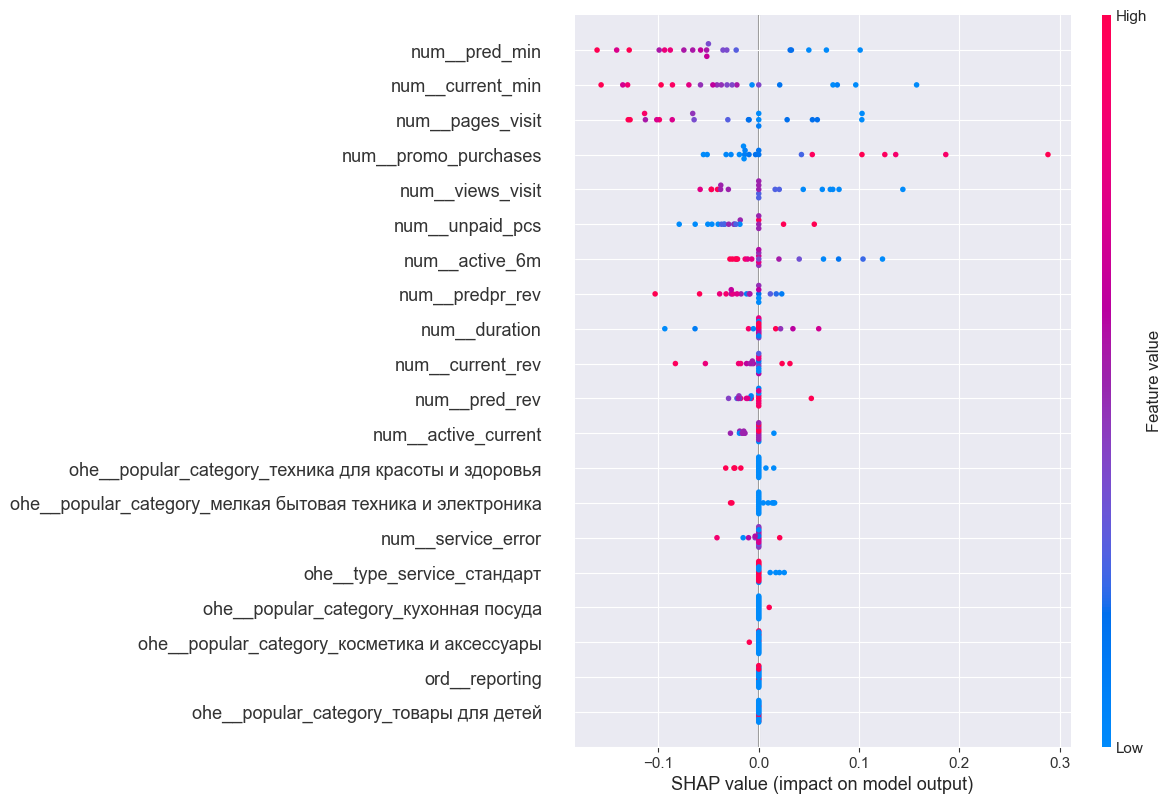

In [314]:
shap.plots.beeswarm(shap_values[:,:,1], max_display = 20)

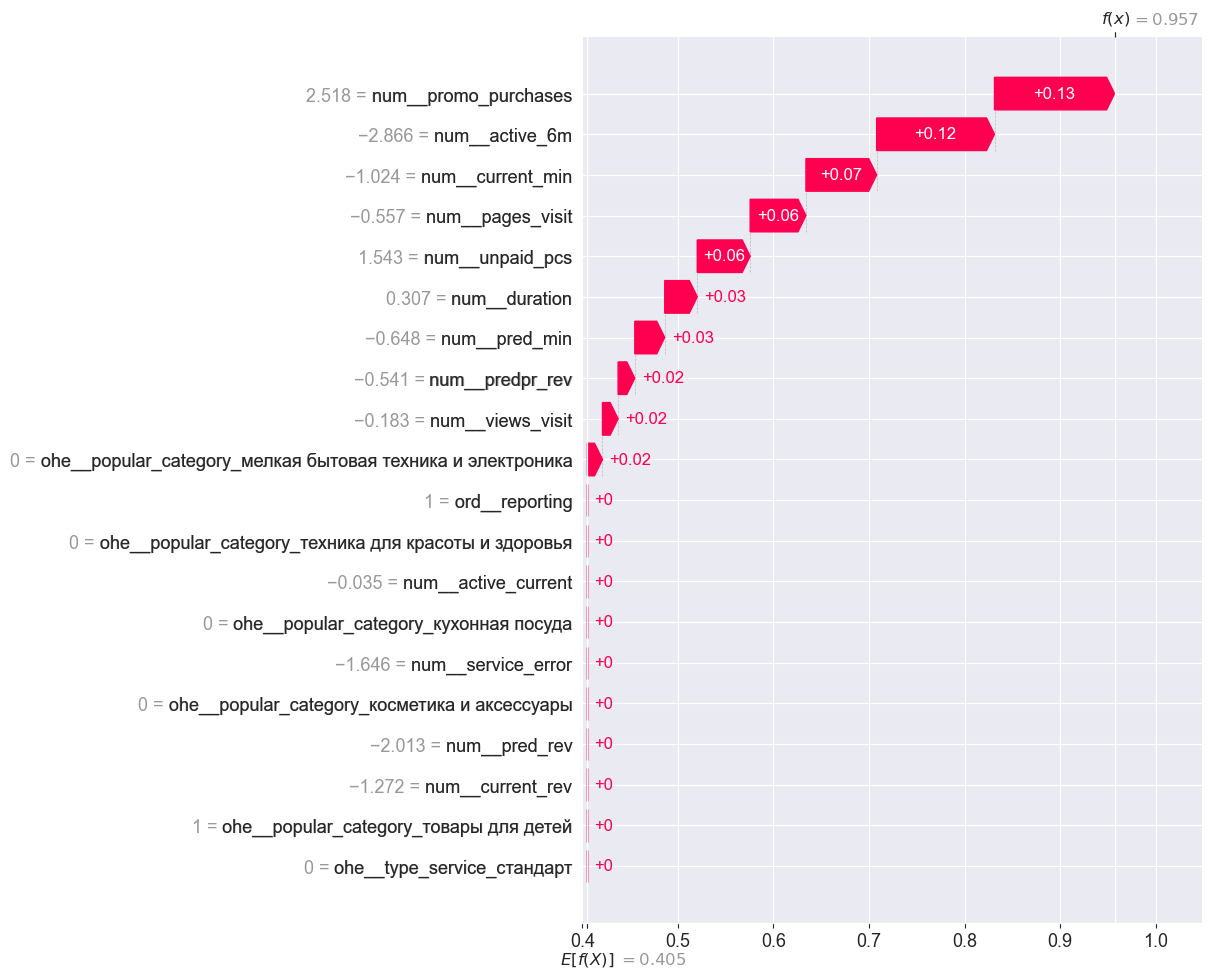

In [315]:
shap.plots.waterfall(shap_values[1,:,1], max_display = 20)

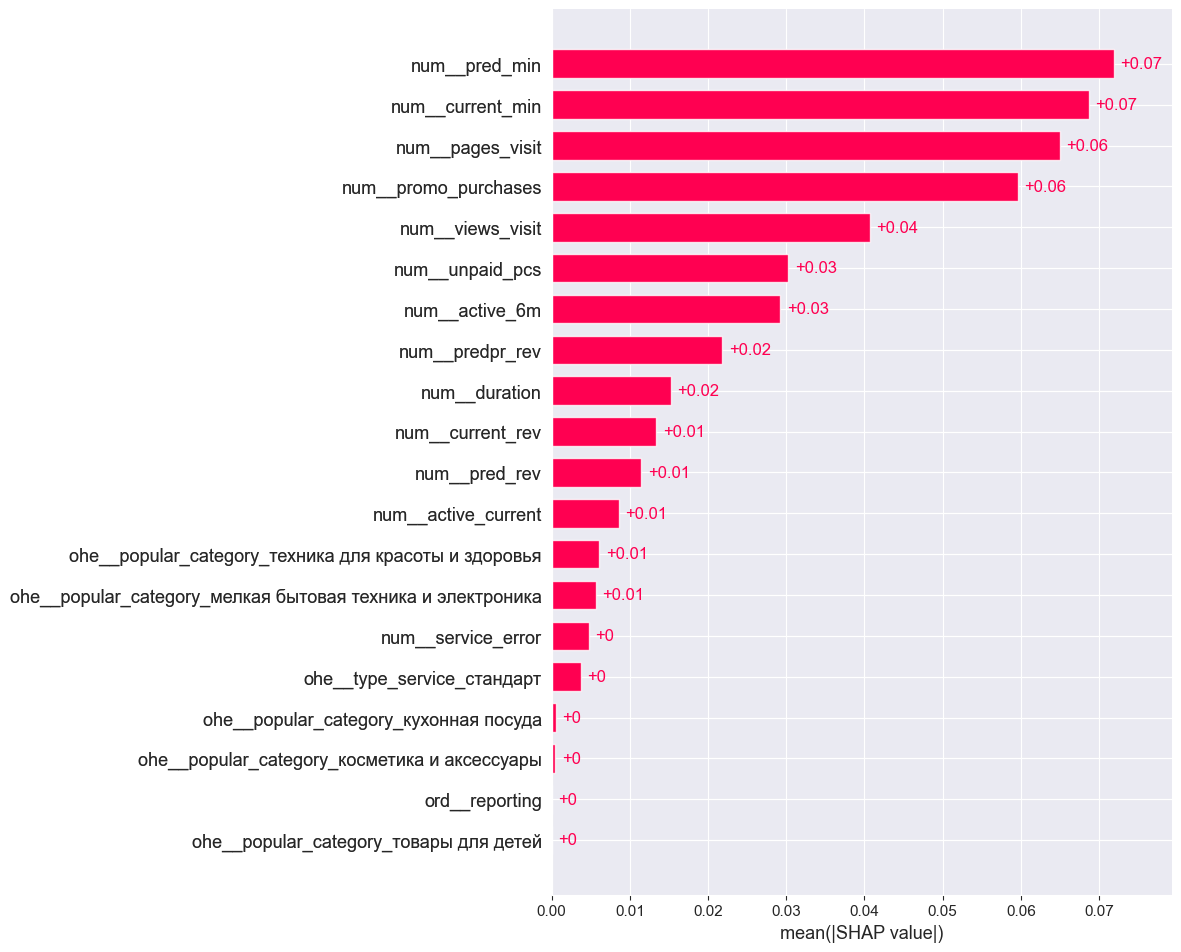

In [316]:
shap.plots.bar(shap_values[:, :, 1], max_display=21)

<div style="background-color:aquamarine; color:#black; text-align:left; padding:2%">
<font size="4", color= "black"><b>Результат:</b> с точки зрения модели наиболее важными признаками для прогноза активности являются:

- мало значимы для модели: 
    - популярные категории (popular_category), 
    - разрешить сообщать (reporting)
    - тип сервиса (type_service) и это меня удивило)
- сильнее всего влияют на целевой признак: 
    - время, проведенное на сайте (current_min, pred_min) и это логично,
    - количество просмотренных за визит категорий и страниц (pages_visit, views_visit),
    - промо-акции (promo_purchases),
    - не оплаченные покупки (unpaid_pcs),
    
Можно использовать эти наблюдения при моделировании и принятии бизнес-решений:
- в части моделирования:
    - popular_category, reporting и type_service имеет смысл исключить из модели
    - использовать feature engineering для создания новых признаков
- в части бизнес-решений:
    - развивать контент-модули, рекомендуемые товары и статьи, чтобы затягивать пользователей (увеличить current_min и pred_min)
    - внедрить напоминания по e-mail или push-уведомления о незавершённых покупках, упростить процесс оплаты: один клик, автозаполнение реквизитов, поддержка популярных платёжных систем для снижения количества не оплаченных покупок (unpaid_pcs)
    - улучшить метрику views_visit - разместите на страницах «схожие товары» и «может понравиться», призывая к просмотру дополнительных карточек, применять персонализацию: выдача продуктов на основе истории просмотров/покупок
    - анализировать, какие типы акций (скидки, купоны, бесплатная доставка) приводят к росту конверсии, и масштабировать наиболее эффективные (promo_purchases)</font>

## Сегментация покупателей

<div style="background-color:lavender; color:#black; text-align:left; padding:2%">
<font size="4", color= "black">Выполним сегментацию покупателей. Будем использовать результаты моделирования и данные о прибыльности покупателей. Учтем рекомендации в самом задании.</font>

In [317]:
money.set_index('id', inplace=True)

In [318]:
predicted = randomized_search.predict_proba(X_test)[:, 1]
X_test = X_test.copy()
X_test['predicted'] = predicted

#segment = X_test.merge(money, left_on='id', right_index=True)
segment = X_test.join(money)

In [319]:
segment = segment.copy()
segment['revenue'] = (
    segment['current_rev']
  + segment['pred_rev']
  + segment['predpr_rev']
)
segment['profit_rub'] = (segment['revenue'] * segment['profit'])/100

In [320]:
print(segment.head(2))

       type_service reporting  active_6m  active_current  duration  \
id                                                                   
216161     стандарт        да       4.10               4       606   
215654      премиум       нет       1.40               4       684   

        promo_purchases                popular_category  views_visit  \
id                                                                     
216161             0.15  техника для красоты и здоровья            6   
215654             0.94                товары для детей            3   

        unpaid_pcs  service_error  pages_visit  pred_rev  predpr_rev  \
id                                                                     
216161           1              4           12  3,973.00    4,912.00   
215654           6              1            6  3,548.00    4,656.00   

        current_rev  pred_min  current_min  predicted  profit   revenue  \
id                                                                

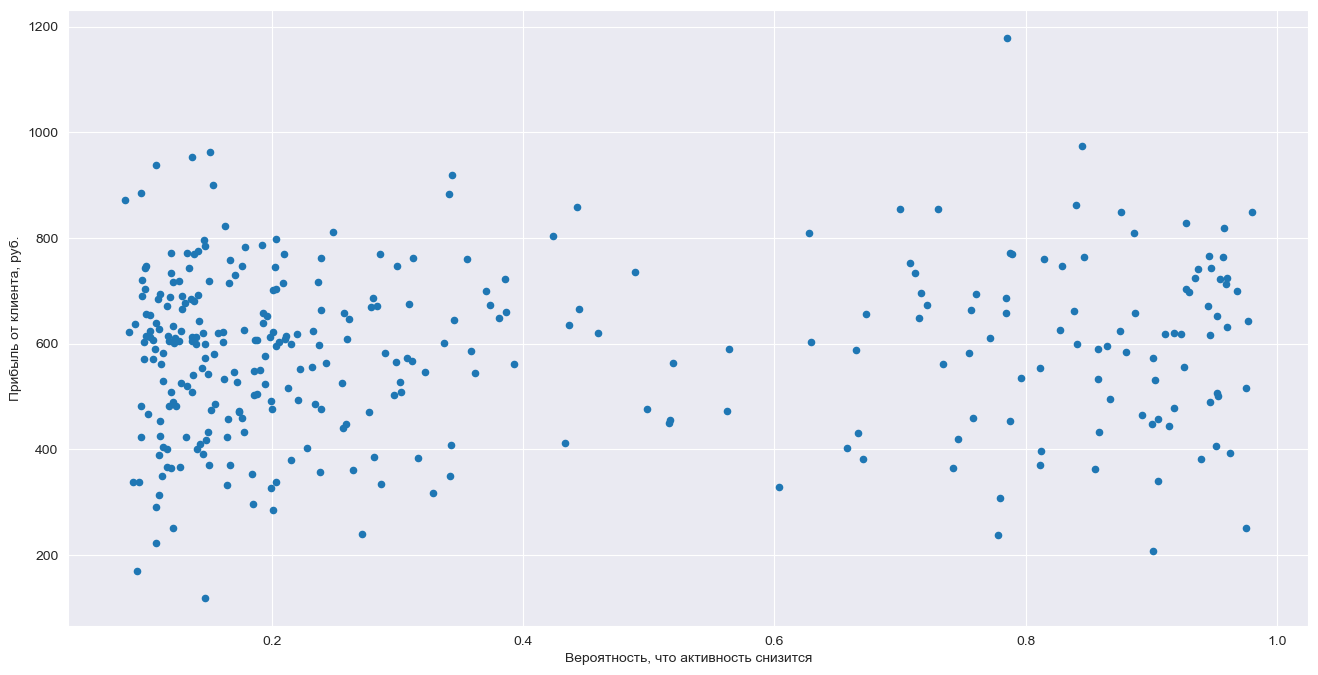

In [321]:
segment.plot.scatter(
    x = 'predicted', 
    y = 'profit_rub', 
    figsize=(16, 8)
)
plt.xlabel('Вероятность, что активность снизится')
plt.ylabel('Прибыль от клиента, руб.')
plt.show()

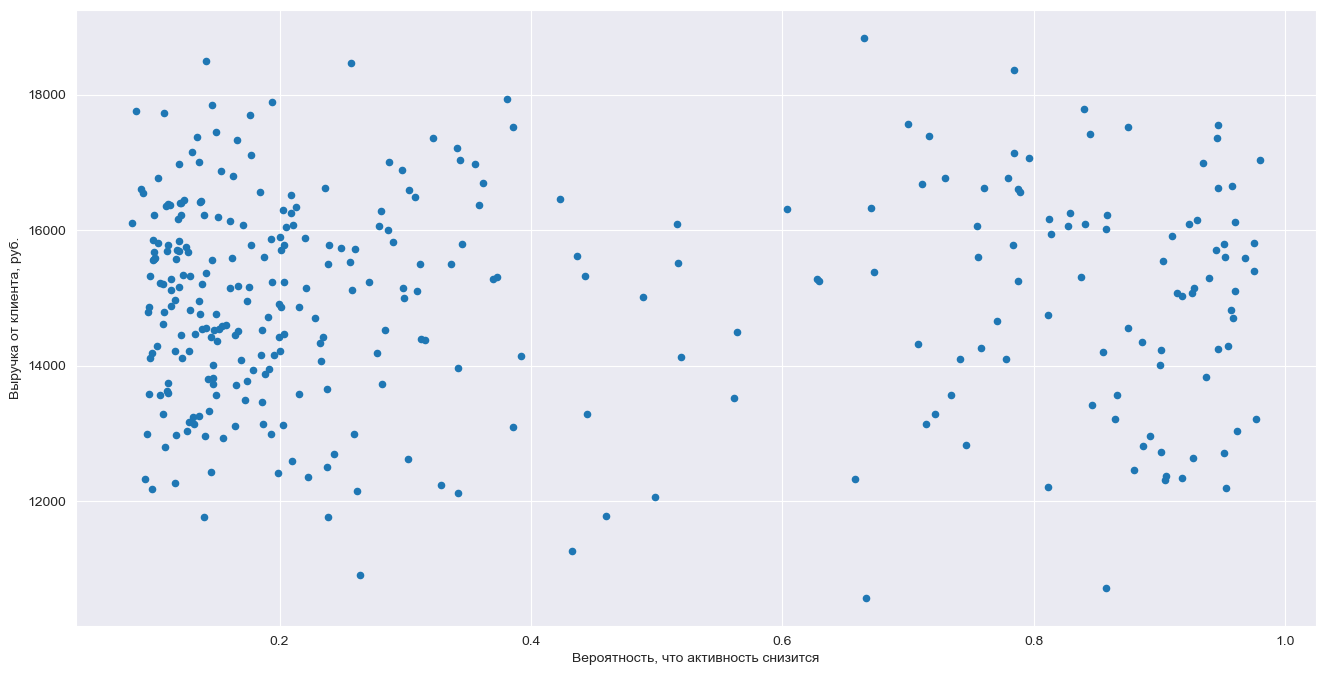

In [322]:
segment.plot.scatter(
    x = 'predicted', 
    y = 'revenue', 
    figsize=(16, 8)
)
plt.xlabel('Вероятность, что активность снизится')
plt.ylabel('Выручка от клиента, руб.')
plt.show()

<div style="background-color:lavender; color:#black; text-align:left; padding:2%">
<font size="4", color= "black">Рассмотрим сегмент клиентов с высокой вероятностью снижения покупательской активности и наиболее высокой прибыльностью за период.</font>

In [323]:
profit_rub_mean = segment['profit_rub'].mean()

In [324]:
segment_low = segment.loc[
    (segment['predicted'] >= 0.6) &
    (segment['profit_rub'] >= profit_rub_mean),
    :
].copy()

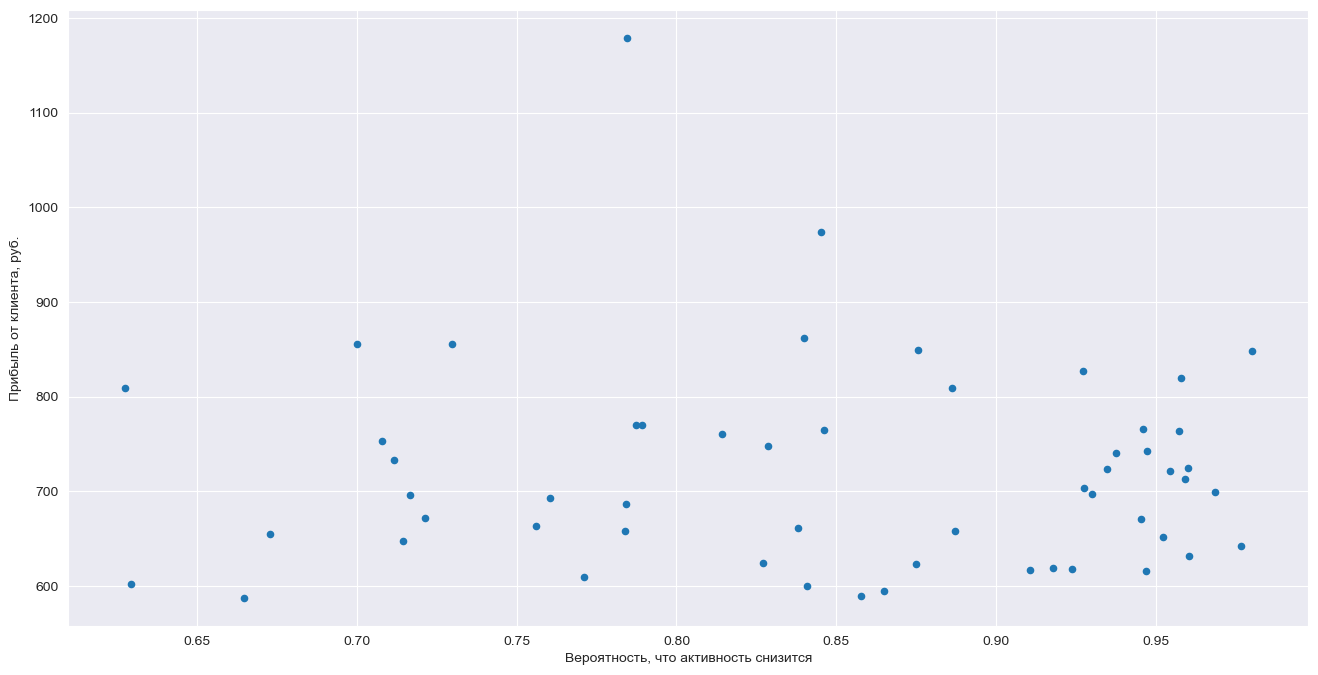

In [325]:
segment_low.plot.scatter(
    x = 'predicted', 
    y = 'profit_rub', 
    figsize=(16, 8)
)
plt.xlabel('Вероятность, что активность снизится')
plt.ylabel('Прибыль от клиента, руб.')
plt.show()

In [326]:
segment_low.reset_index(drop=True).phik_matrix().style.background_gradient(cmap='coolwarm')

interval columns not set, guessing: ['active_6m', 'active_current', 'duration', 'promo_purchases', 'views_visit', 'unpaid_pcs', 'service_error', 'pages_visit', 'pred_rev', 'predpr_rev', 'current_rev', 'pred_min', 'current_min', 'predicted', 'profit', 'revenue', 'profit_rub']


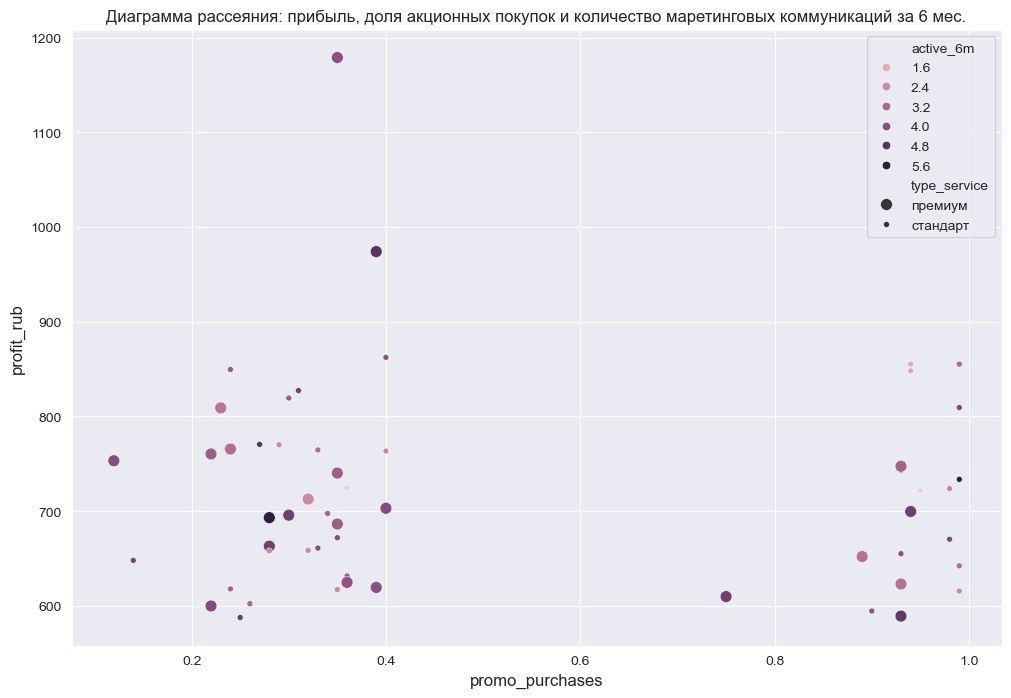

In [327]:
plot_scatter(
    segment_low, 
    x='promo_purchases', 
    hue='active_6m', 
    title='Диаграмма рассеяния: прибыль, доля акционных покупок и количество маретинговых коммуникаций за 6 мес.'
)

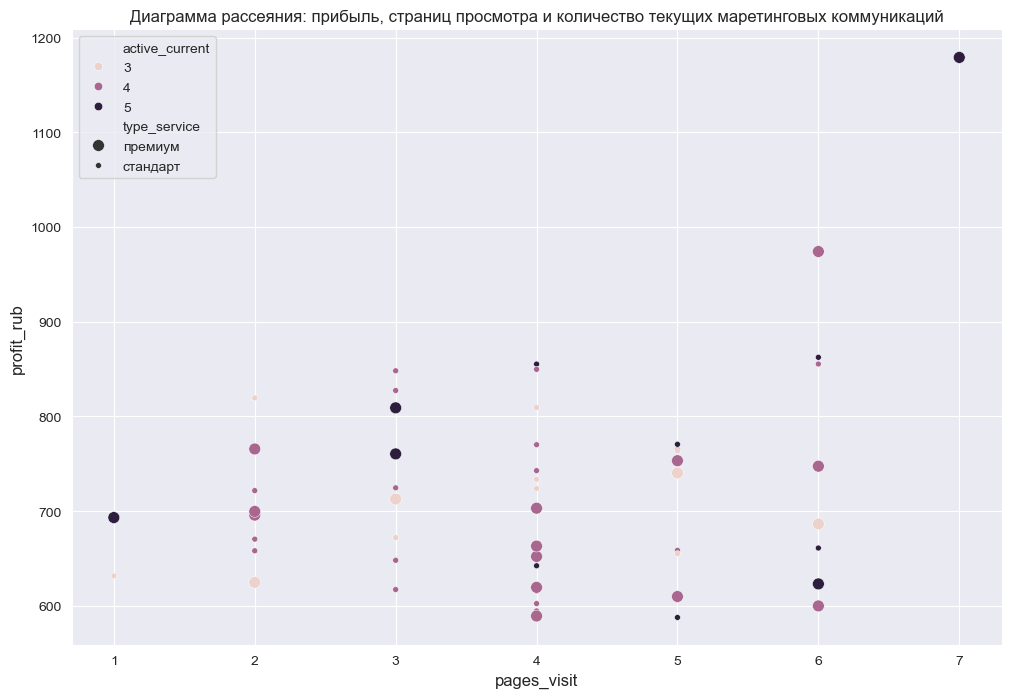

In [328]:
plot_scatter(
    segment_low, 
    x='pages_visit', 
    hue='active_current', 
    title='Диаграмма рассеяния: прибыль, страниц просмотра и количество текущих маретинговых коммуникаций'
)

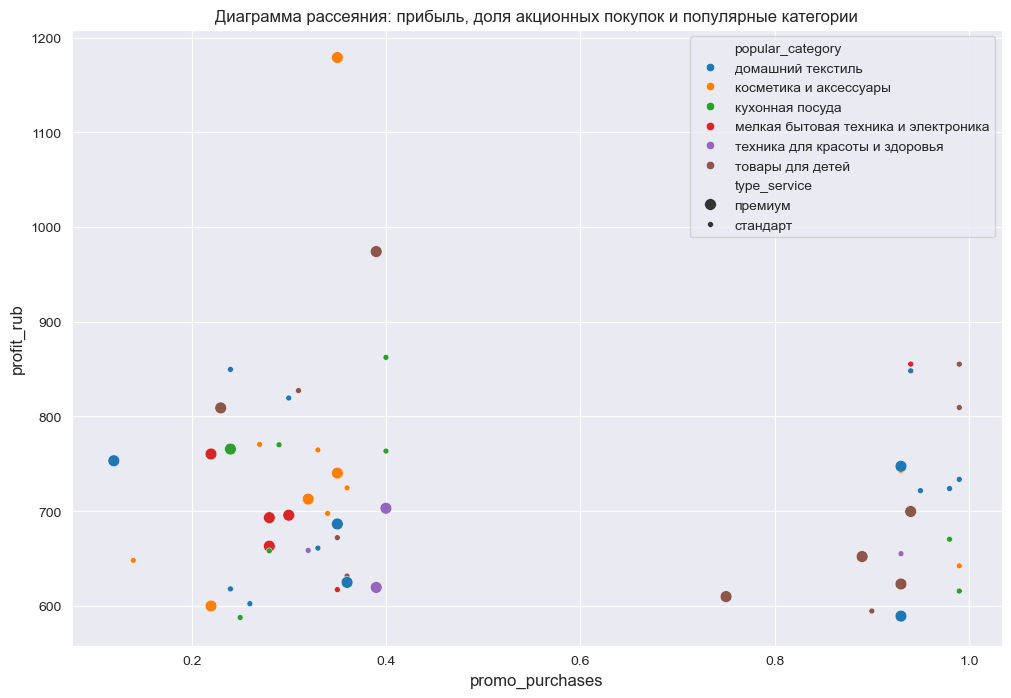

In [329]:
plot_scatter(
    segment_low, 
    x='promo_purchases', 
    hue='popular_category', 
    title='Диаграмма рассеяния: прибыль, доля акционных покупок и популярные категории'
)

<div style="background-color:lavender; color:#black; text-align:left; padding:2%">
<font size="4", color= "black">Рассмтрим сегмент клиентов с низкой вероятностью снижения покупательской активности и наиболее высокой прибыльностью. Что удерживает их?)</font>

In [330]:
segment_high = segment.loc[
    (segment['predicted'] < 0.6) &
    (segment['profit_rub'] >= profit_rub_mean),
    :
].copy()

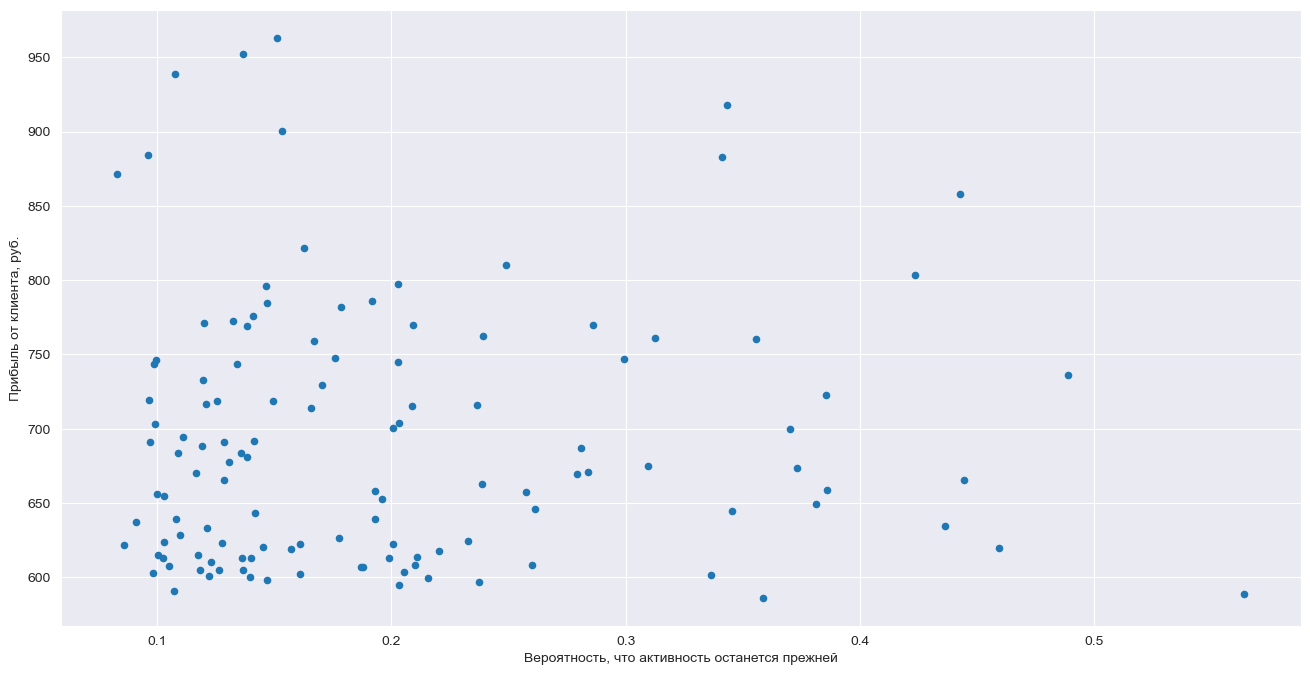

In [331]:
segment_high.plot.scatter(
    x = 'predicted', 
    y = 'profit_rub', 
    figsize=(16, 8)
)
plt.xlabel('Вероятность, что активность останется прежней')
plt.ylabel('Прибыль от клиента, руб.')
plt.show()

In [332]:
segment_high.reset_index(drop=True).phik_matrix().style.background_gradient(cmap='coolwarm')

interval columns not set, guessing: ['active_6m', 'active_current', 'duration', 'promo_purchases', 'views_visit', 'unpaid_pcs', 'service_error', 'pages_visit', 'pred_rev', 'predpr_rev', 'current_rev', 'pred_min', 'current_min', 'predicted', 'profit', 'revenue', 'profit_rub']


In [333]:
segment_low = segment_low.copy()
segment_low['rev_promo_low']    = segment_low['revenue'] * segment_low['promo_purchases']
segment_low['rev_nonpromo_low'] = segment_low['revenue'] * (1 - segment_low['promo_purchases'])
rev_by_cat_low = (
    segment_low
    .groupby('popular_category', observed=True)[['rev_promo_low','rev_nonpromo_low']]
    .sum()
)
order_low = rev_by_cat_low.sum(axis=1).sort_values(ascending=False).index
rev_by_cat_low = rev_by_cat_low.loc[order_low]

segment_high = segment_high.copy()
segment_high['rev_promo_high']    = segment_high['revenue'] * segment_high['promo_purchases']
segment_high['rev_nonpromo_high'] = segment_high['revenue'] * (1 - segment_high['promo_purchases'])
rev_by_cat_high = (
    segment_high
    .groupby('popular_category', observed=True)[['rev_promo_high','rev_nonpromo_high']]
    .sum()
)
order_high = rev_by_cat_high.sum(axis=1).sort_values(ascending=False).index
rev_by_cat_high = rev_by_cat_high.loc[order_high]

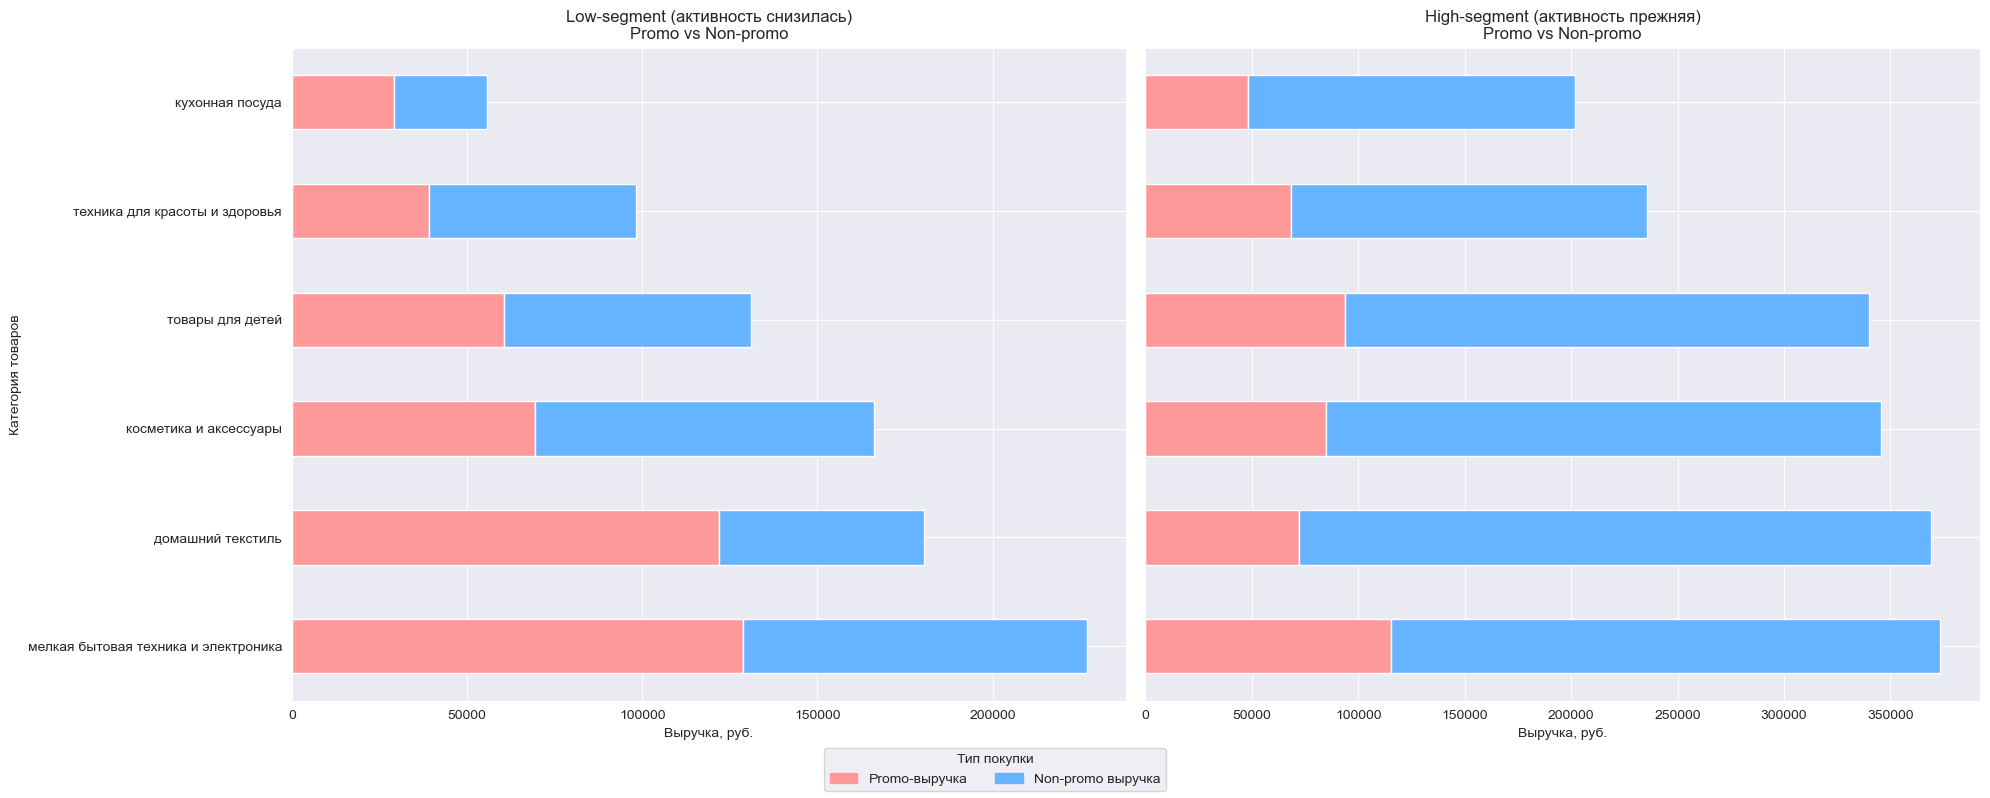

In [334]:
fig, axes = plt.subplots(ncols=2, figsize=(20, 8), sharey=True)

colors = ['#FF9999', '#66B3FF']

rev_by_cat_low.plot(
    kind='barh', stacked=True, ax=axes[0],
    color=colors, legend=False
)
axes[0].set_title('Low-segment (активность снизилась)\nPromo vs Non-promo')
axes[0].set_xlabel('Выручка, руб.')
axes[0].set_ylabel('Категория товаров')

rev_by_cat_high.plot(
    kind='barh', stacked=True, ax=axes[1],
    color=colors, legend=False
)
axes[1].set_title('High-segment (активность прежняя)\nPromo vs Non-promo')
axes[1].set_xlabel('Выручка, руб.')
axes[1].set_ylabel('')

legend_handles = [
    Patch(color=colors[0], label='Promo-выручка'),
    Patch(color=colors[1], label='Non-promo выручка')
]
fig.legend(
    handles=legend_handles,
    title='Тип покупки',
    loc='lower center',
    ncol=2
)

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()

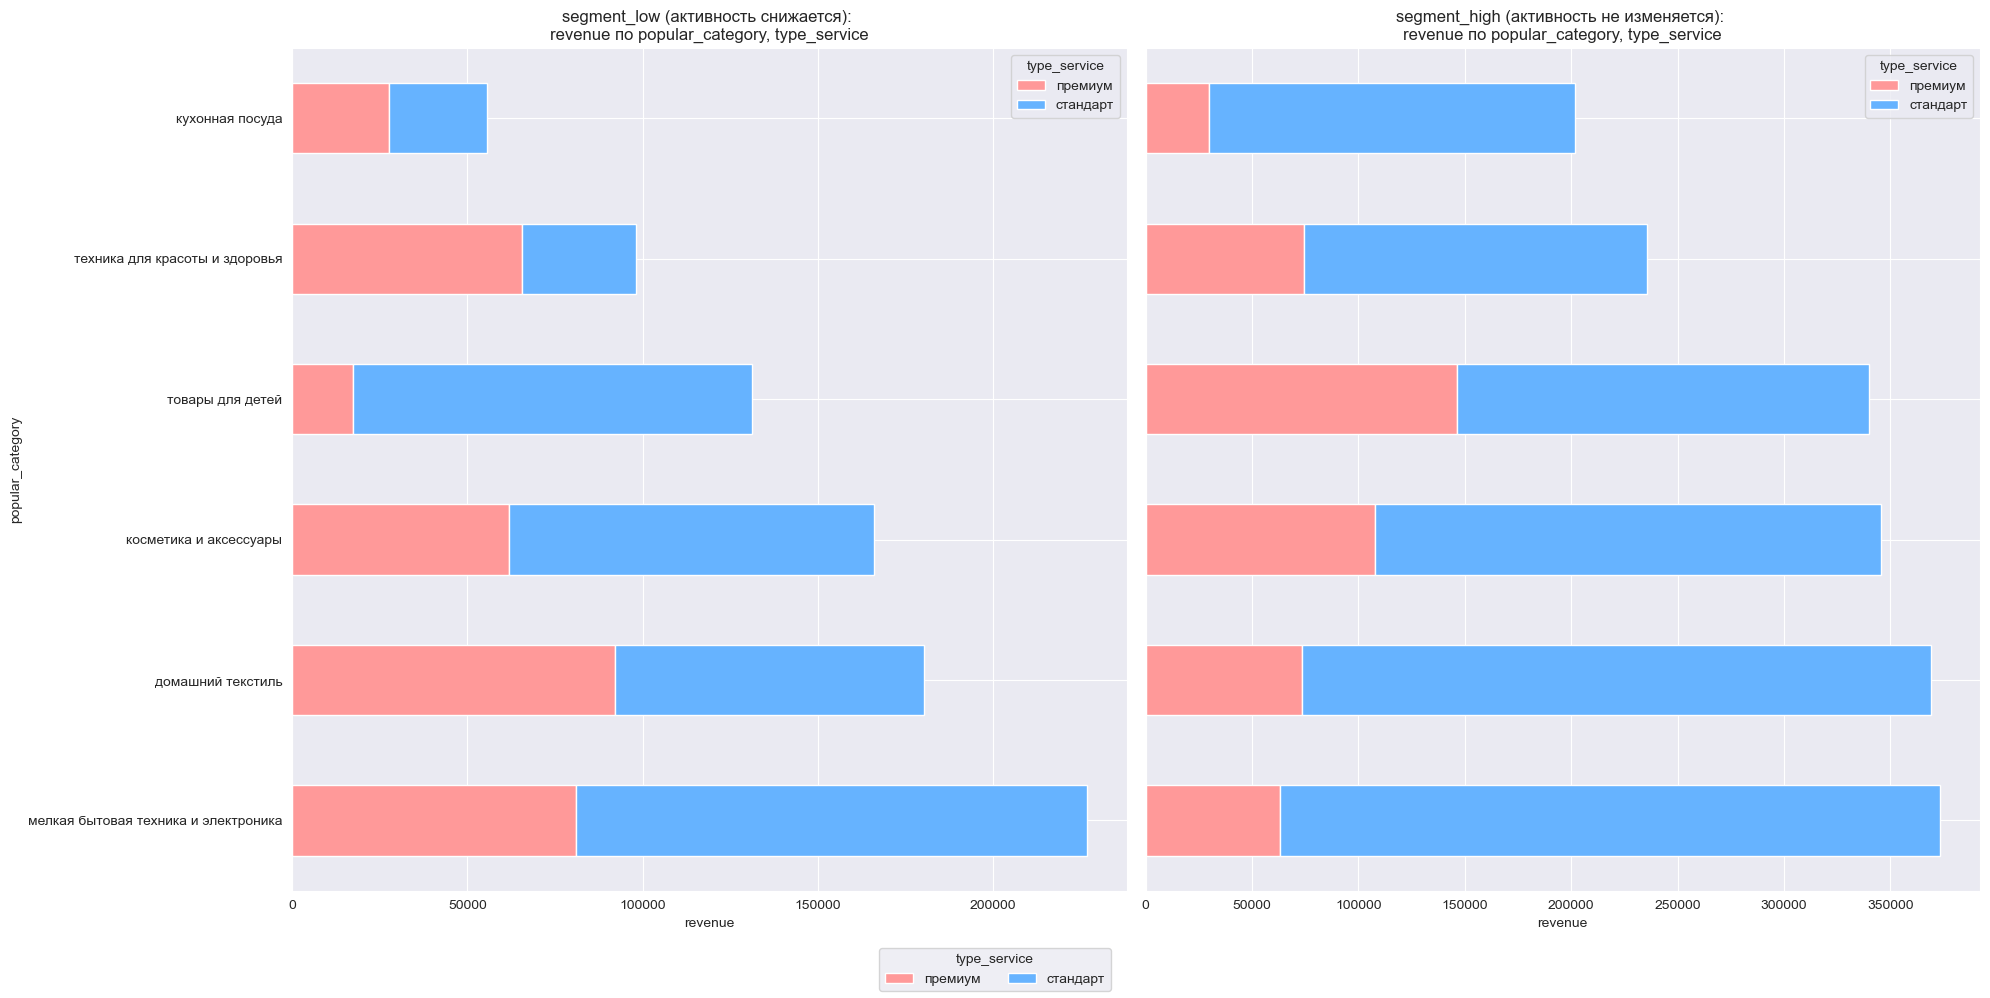

In [335]:
plot_segment_comparison(
    df_1=segment_low,
    df_2=segment_high,
    groupby_cols=['popular_category', 'type_service'],
    value_col='revenue',
    segment_names=('segment_low (активность снижается)', 'segment_high (активность не изменяется)'),
    top_n=None
)

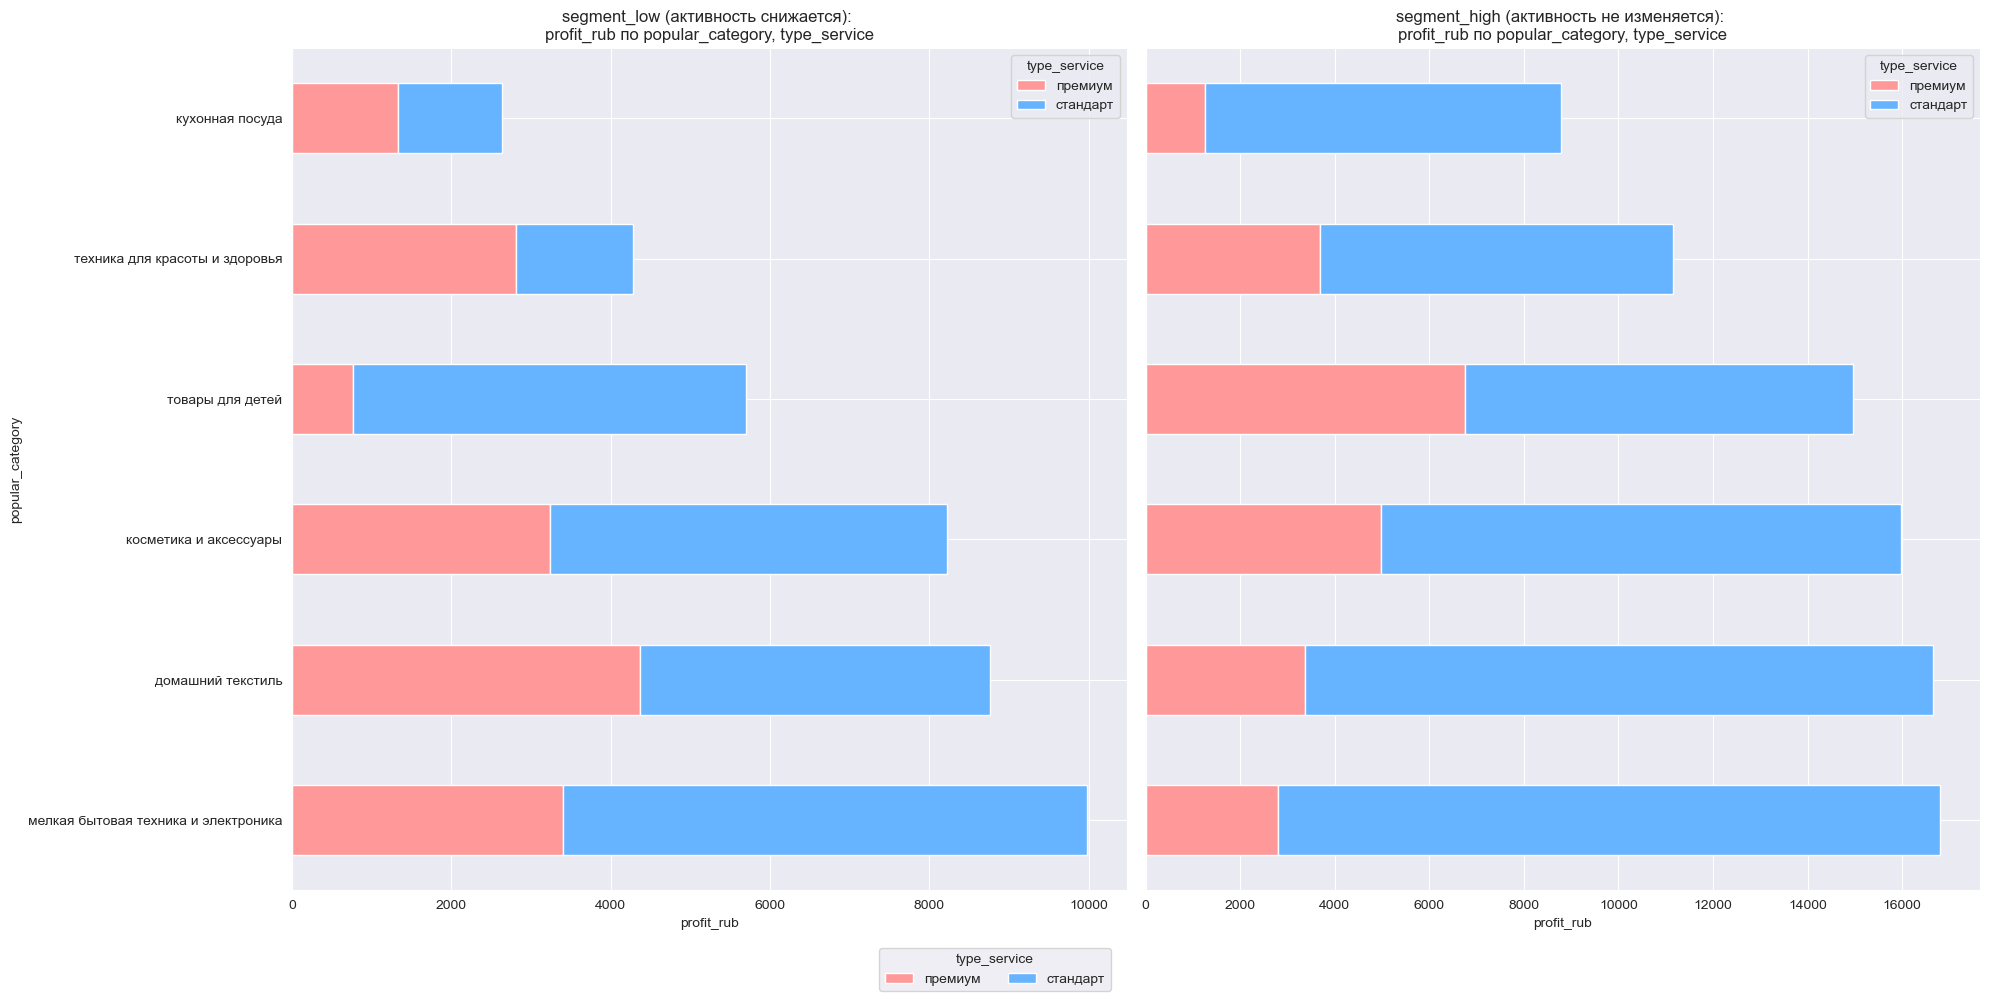

In [336]:
plot_segment_comparison(
    df_1=segment_low,
    df_2=segment_high,
    groupby_cols=['popular_category', 'type_service'],
    value_col='profit_rub',
    segment_names=('segment_low (активность снижается)', 'segment_high (активность не изменяется)'),
    top_n=None
)

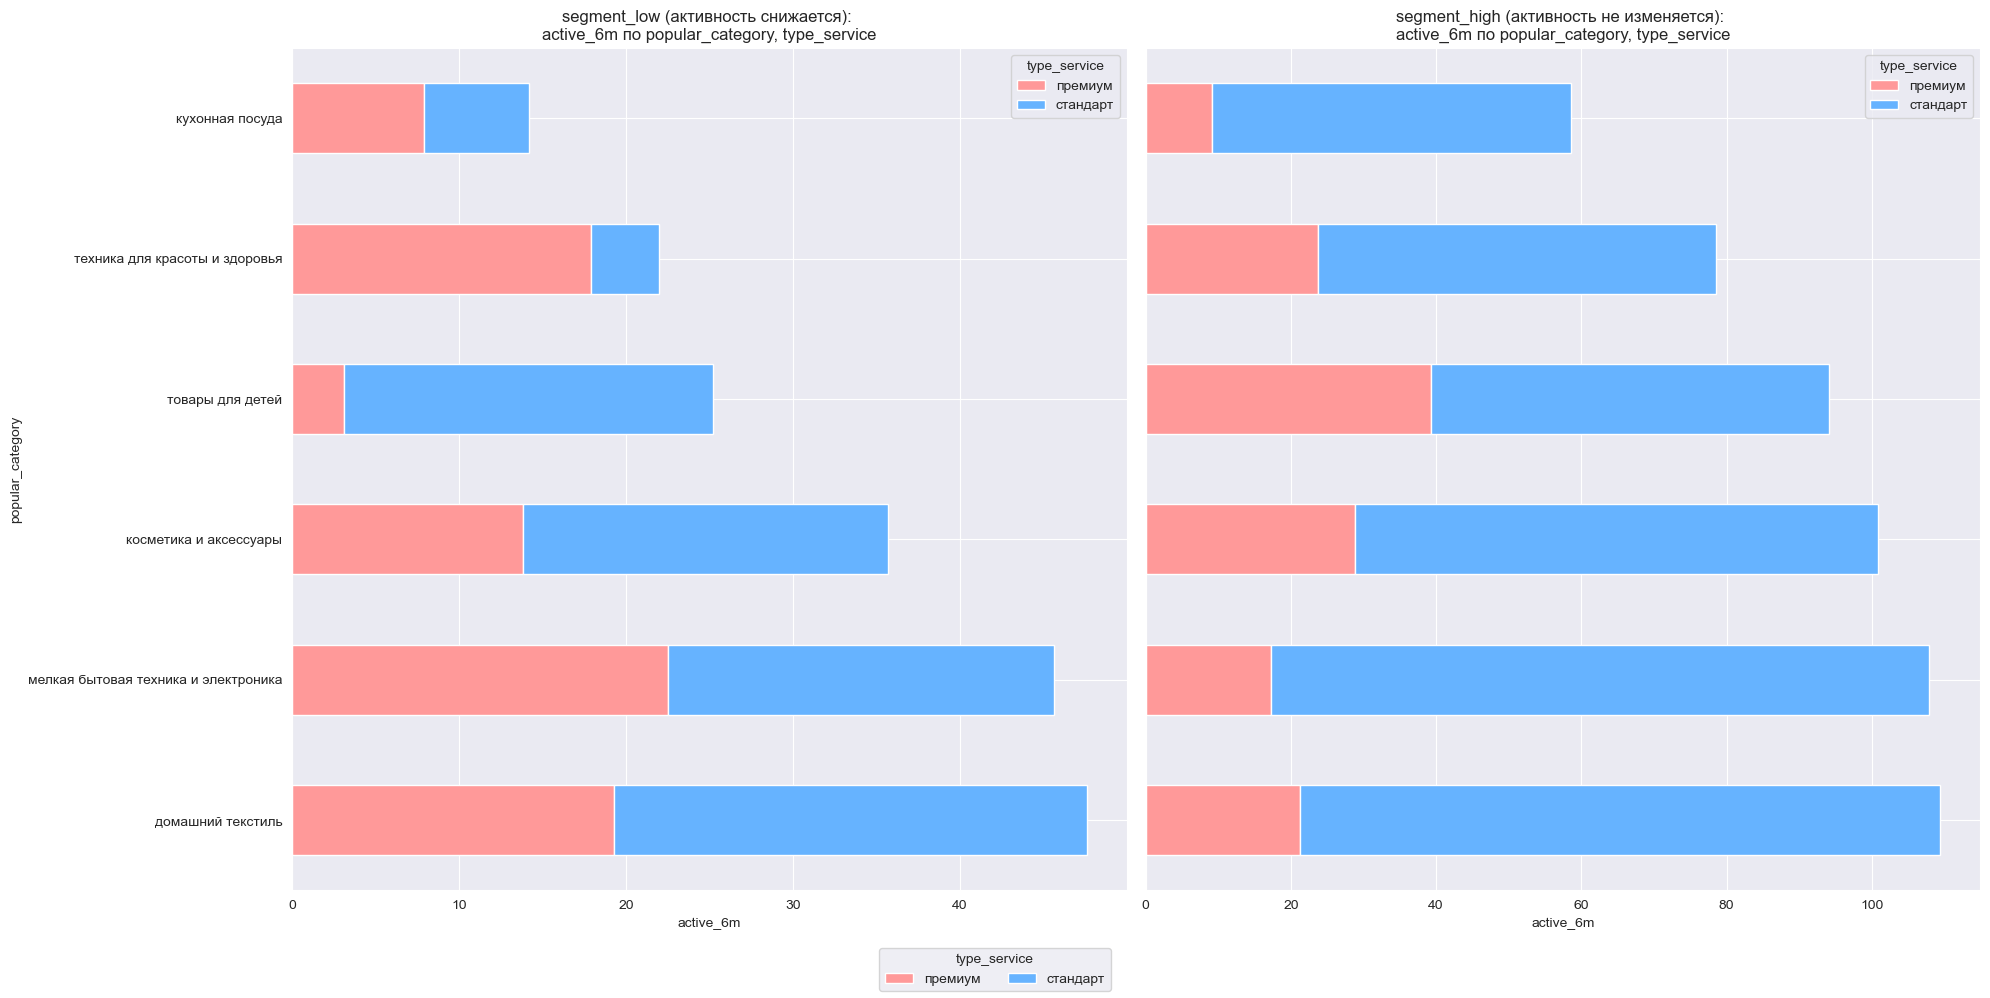

In [337]:
plot_segment_comparison(
    df_1=segment_low,
    df_2=segment_high,
    groupby_cols=['popular_category', 'type_service'],
    value_col='active_6m',
    segment_names=('segment_low (активность снижается)', 'segment_high (активность не изменяется)'),
    top_n=None
)

<div style="background-color:aquamarine; color:#black; text-align:left; padding:2%">
<font size="4", color= "black"><b>Результат:</b> Мы сделали сегментацию покупателей следующим образом:
    
- группа покупателей, вероятность снижения покупательской активности которых более 60% и прибыльность за отчетный период больше средней,
- группа покупателей, вероятность снижения покупательской активности которых менее 60% и прибыльность за отчетный период больше средней
    
Второй сегмент выбран с целью анализа возможных причин, почему активность этих покупателей не снизилась и выработки рекомендаций для работы с первым сегментом.
    
Рекомендации бизнесу:
- лояльные покупатели приносят большую прибыль и выручку, чем те, чья активность снижается
- покупатели, имеющие детей, чаще используют подписку премиум, нужно активизировать рекламу для данного сегмента
- лояльные покупатели реже осуществляют покупки по акциям, но в целом на них приходится больший маркетинговый бюджет,
- основной упор нужно сделать на удержании покупателей и мотивацию их на большее время провождения на сайте</font>

## Общий вывод

<div style="background-color:aquamarine; color:#black; text-align:left; padding:2%">
<font size="4", color= "black">Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.<br>

<b>Основные выводы и обоснования:</b><br>
- Данные оказались почти идеальными: удалено два неявных дубликата и один выброс, пропусков нет. 
- Лучшей моделью оказалась SVC(C=2, probability=True, random_state=42). Значение метрики ROC_AUC на тесте = 0.91.
- Акционные покупки — главный фактор повторных заказов.
- Модель показала, что наличие промо-маркировки и повышает вероятность следующей покупки сильнее любого другого признака. Значит, стоит чаще и точнее таргетировать акции, особенно персональные.
- Тип сервиса («Премиум» vs «Стандарт») тоже влияет на конверсию.
- Среднее число просмотренных категорий за визит — лучший предиктор удержания. Нужно расширять «витрину»: рекомендации, подборки, быстрые фильтры.
- Сегмент «высокая прибыль, высокий риск оттока» почти не реагирует на классические акции, исключение - товарные категории "Косметика и аксессуары" и "Домашний текстиль".
- Максимальная выручка и прибыль у лояльных покупателей по категориям "Товары для детей", "Мелкая бытовая техника и электроника", "Косметика и аксессуары" и "Домашний текстиль".
- Максимальная выручка и прибыль у покупателей со сниженной активностью - по категориям "Косметика и аксессуары" и "Домашний текстиль".
- Покупатели, посещающие мало страниц за визит, имеют одни из самых наибольших вероятностей, на снижение своей активности. Необходимо придумать что-нибудь, для их дальнейшего удержания, например систему рекомендаций товаров на основе их предыдущих предпочтений.
</font>